In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score, f1_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential, Model
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from evaluation import calculate_metrics, plot_ROC

In [3]:
def model_predict_class(model, data):
    if type(model) == keras.models.Model:
        y = model.predict(data)
        return (y >= 0.5)*1
    else:
        return model.predict_classes(data)

In [9]:
import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        inputs_L = len(self.model.inputs)
        predict = np.squeeze(model_predict_class(self.model, self.validation_data[:inputs_L]))
        targ = np.squeeze(self.validation_data[inputs_L])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, e=25, BS=128, focal=False,alpha=0.6,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    
    
    #print("Best f1 macro trough iters %f on %d "%(np.max(metrics.val_f1s),np.argmax(metrics.val_f1s)))

    #predichos=aux_model.predict_classes(x_val)
    #calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

In [6]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
labels.shape

(8054,)

In [7]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

KOI Name        Set
0  K00889.01      Train
1  K01009.01      Train
2  K07621.01      Train
3  K06252.01      Train
4  K00958.01  Unlabeled

In [8]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

KOI Name NExScI Disposition  Kepler Name      Period  \
0  K00889.01          CONFIRMED  Kepler-75 b    8.884923   
1  K01009.01     FALSE POSITIVE          NaN    5.092465   
2  K07621.01     FALSE POSITIVE          NaN  275.073650   
3  K06252.01     FALSE POSITIVE          NaN    8.460439   
6  K04162.01     FALSE POSITIVE          NaN    0.539366   

   Time of Transit Epoch  First Transit Time (BJD)  Impact Parameter  \
0             169.991686               2455002.992             0.069   
1             357.535940               2455190.536             0.161   
2             315.248600               2455148.249             0.595   
3             133.774490               2454966.774             1.061   
6             131.974570               2454964.975             0.988   

   Duration  Transit Depth    r/R  ...    Teff  log(g)  Metallicity  \
0   2.07004        16053.4  0.114  ...  5332.0   4.500        -0.08   
1   3.65900          254.0  0.014  ...  5037.0   4.547        -0.20   
2   3.37000          228.9  0.014  ...  5604.0   4.226        -0.12   
3   4.73492        76412.9  0.478  ...  5951.0   4.638        -1.06   
6   5.43400          145.0  0.016  ...  6341.0   3.301        -0.10   

   Stellar Radius  Stellar Mass  Max single event sigma  Max Multievent sigma  \
0           0.843         0.821                  61.291               474.021   
1           0.751         0.727                   3.648                15.175   
2           1.187         0.864                   5.909                 8.012   
3           0.702         0.796                 452.526              3704.503   
6           5.302         2.050                   4.847                 9.076   

   Transit Model SNR  KOI count  Transit Number  
0              388.2          1             153  
1               17.1          1             225  
2                7.5          1               4  
3             1797.4          1             164  
6               57.6          1            1239  

[5 rows x 31 columns]

In [10]:
y_all = (df_meta['NExScI Disposition'].values=="CONFIRMED")*1
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2790   1:1597
y_val distribution:   0:1186   1:684


## Carga de datos

#### Metadata 

In [8]:
names_m = ['Period', 'Duration', 'Time of Transit Epoch', 'r/R', 'a/R','Inclination', 
        'Impact Parameter', 'Fitted Stellar Density','Limb Darkening Coeff1', 'Limb Darkening Coeff2']
metadata_transit = np.load("../obj4/LC_features/MetadataLC.npy") #nans vienen imputados con mediana...
df_meta_obj = pd.DataFrame(metadata_transit, columns=names_m)

#del_val = ["Impact Parameter", "Fitted Stellar Density", "Duration"] 
#df_meta_obj.drop(del_val, axis=1, inplace=True)  #cortar a las 7 de M-A

x_all = df_meta_obj.values

from sklearn.preprocessing import StandardScaler, RobustScaler
x_all = StandardScaler().fit_transform(x_all)

x_train = x_all[mask_train]
x_val = x_all[mask_test]

print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

meta = Sequential()
meta.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
meta.add(Dropout(0.5))
meta.add(Dense(1, activation='sigmoid'))
meta.summary()

Objetos de entrenamiento: (4387, 10) (4387,)
Objetos de validación: (1870, 10) (1870,)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1408      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 242us/step - loss: 0.6268 - acc: 0.6379 - val_loss: 0.6280 - val_acc: 0.5876
 - val_f1: 0.535735 
Epoch 2/200
3905/3905 [==============================] - 0s 14us/step - loss: 0.5320 - acc: 0.7155 - val_loss: 0.5980 - val_acc: 0.6175
 - val_f1: 0.582305 
Epoch 3/200
3905/3905 [==============================] - 0s 14us/step - loss: 0.4958 - acc: 0.7539 - val_loss: 0.5641 - val_acc: 0.6682
 - val_f1: 0.653293 
Epoch 4/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.4658 - acc: 0.7729 - val_loss: 0.5405 - val_acc: 0.7120
 - val_f1: 0.702111 
Epoch 5/200
3905/3905 [==============================] - 0s 12us/step - loss: 0.4470 - acc: 0.7910 - val_loss: 0.5164 - val_acc: 0.7488
 - val_f1: 0.744119 
Epoch 6/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.4275 - acc: 0.8026 - val_loss: 0.5002 - val_acc: 0.7719
 - val_f1: 0.768695 
Epoch 7/20

 - val_f1: 0.829315 
Epoch 53/200
3905/3905 [==============================] - 0s 14us/step - loss: 0.2954 - acc: 0.8786 - val_loss: 0.3580 - val_acc: 0.8272
 - val_f1: 0.826857 
Epoch 54/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.2941 - acc: 0.8773 - val_loss: 0.3518 - val_acc: 0.8433
 - val_f1: 0.843265 
Epoch 55/200
3905/3905 [==============================] - 0s 12us/step - loss: 0.2964 - acc: 0.8807 - val_loss: 0.3531 - val_acc: 0.8295
 - val_f1: 0.829315 
Epoch 56/200
3905/3905 [==============================] - 0s 12us/step - loss: 0.2977 - acc: 0.8802 - val_loss: 0.3517 - val_acc: 0.8318
 - val_f1: 0.831646 
Epoch 57/200
3905/3905 [==============================] - 0s 12us/step - loss: 0.2967 - acc: 0.8717 - val_loss: 0.3549 - val_acc: 0.8272
 - val_f1: 0.826857 
Epoch 58/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.2950 - acc: 0.8778 - val_loss: 0.3527 - val_acc: 0.8318
 - val_f1: 0.831646 
Epoch 59/200
3905/3905 [=======

 - val_f1: 0.843265 
Epoch 105/200
3905/3905 [==============================] - 0s 14us/step - loss: 0.2848 - acc: 0.8814 - val_loss: 0.3465 - val_acc: 0.8364
 - val_f1: 0.836300 
Epoch 106/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.2812 - acc: 0.8853 - val_loss: 0.3459 - val_acc: 0.8387
 - val_f1: 0.838586 
Epoch 107/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.2807 - acc: 0.8850 - val_loss: 0.3401 - val_acc: 0.8410
 - val_f1: 0.840993 
Epoch 108/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.2831 - acc: 0.8817 - val_loss: 0.3445 - val_acc: 0.8364
 - val_f1: 0.836300 
Epoch 109/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.2840 - acc: 0.8843 - val_loss: 0.3429 - val_acc: 0.8341
 - val_f1: 0.833974 
Epoch 110/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.2823 - acc: 0.8883 - val_loss: 0.3443 - val_acc: 0.8341
 - val_f1: 0.833974 
Epoch 111/200
3905/3905 [

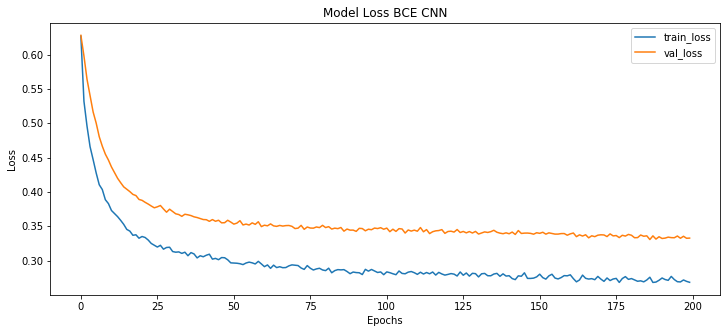

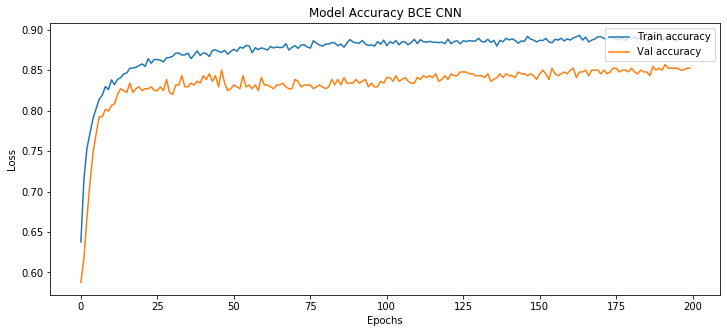

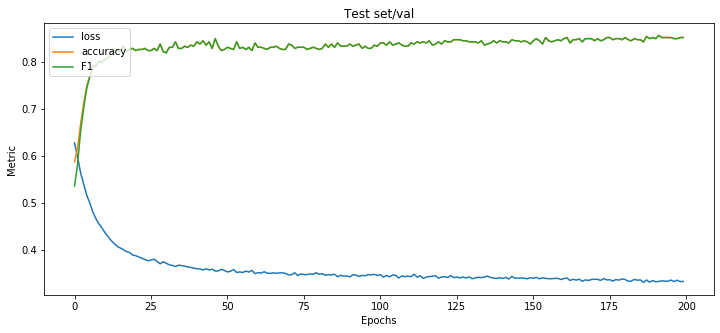

In [35]:
train_model(meta, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_metadata.hdf5')

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.946208    0.860465  0.901302     0.879327  0.869895   
Confirmed            0.778061    0.909091  0.838488     0.879327  0.869895   

                F1 micro  
False Positive  0.877477  
Confirmed       0.877477

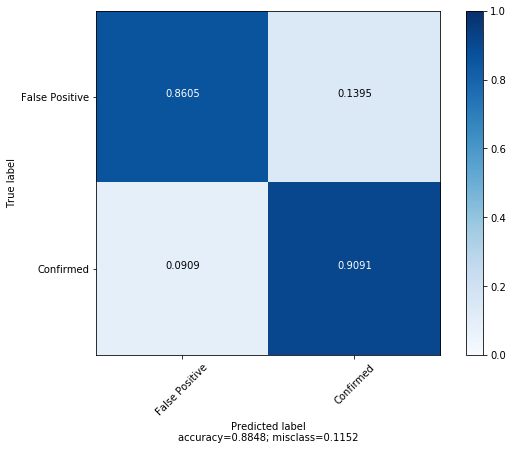

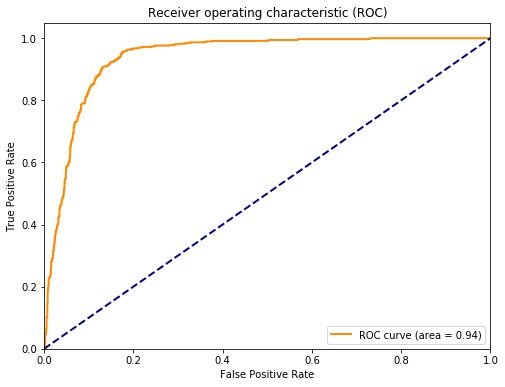

In [36]:
meta_loaded = keras.models.load_model("./models/baseline_metadata.hdf5") #con 4 capas (64 y 128) con dropa en todo
#meta_loaded.summary()

predichos=meta_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - METADATA') #con 3 capas aumentando/double

predichos_prob = meta_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 311us/step - loss: 0.6266 - acc: 0.6335 - val_loss: 0.6247 - val_acc: 0.6060
 - val_f1: 0.550074 
Epoch 2/200
3905/3905 [==============================] - 0s 15us/step - loss: 0.5399 - acc: 0.7170 - val_loss: 0.5931 - val_acc: 0.6452
 - val_f1: 0.617862 
Epoch 3/200
3905/3905 [==============================] - 0s 14us/step - loss: 0.5000 - acc: 0.7547 - val_loss: 0.5574 - val_acc: 0.6935
 - val_f1: 0.679456 
Epoch 4/200
3905/3905 [==============================] - 0s 14us/step - loss: 0.4716 - acc: 0.7752 - val_loss: 0.5302 - val_acc: 0.7212
 - val_f1: 0.714801 
Epoch 5/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.4516 - acc: 0.7867 - val_loss: 0.5039 - val_acc: 0.7512
 - val_f1: 0.749230 
Epoch 6/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.4380 - acc: 0.7959 - val_loss: 0.4889 - val_acc: 0.7604
 - val_f1: 0.758708 
Epoch 7/20

 - val_f1: 0.817623 
Epoch 53/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.3489 - acc: 0.8410 - val_loss: 0.3977 - val_acc: 0.8226
 - val_f1: 0.821990 
Epoch 54/200
3905/3905 [==============================] - 0s 12us/step - loss: 0.3483 - acc: 0.8387 - val_loss: 0.3945 - val_acc: 0.8249
 - val_f1: 0.824434 
Epoch 55/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.3413 - acc: 0.8461 - val_loss: 0.3923 - val_acc: 0.8272
 - val_f1: 0.826783 
Epoch 56/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.3420 - acc: 0.8405 - val_loss: 0.3927 - val_acc: 0.8203
 - val_f1: 0.819894 
Epoch 57/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.3434 - acc: 0.8487 - val_loss: 0.3937 - val_acc: 0.8295
 - val_f1: 0.829054 
Epoch 58/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.3417 - acc: 0.8443 - val_loss: 0.3947 - val_acc: 0.8180
 - val_f1: 0.817366 
Epoch 59/200
3905/3905 [=======

 - val_f1: 0.826058 
Epoch 105/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.3276 - acc: 0.8540 - val_loss: 0.3801 - val_acc: 0.8226
 - val_f1: 0.821549 
Epoch 106/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.3272 - acc: 0.8574 - val_loss: 0.3792 - val_acc: 0.8203
 - val_f1: 0.819414 
Epoch 107/200
3905/3905 [==============================] - 0s 14us/step - loss: 0.3258 - acc: 0.8586 - val_loss: 0.3781 - val_acc: 0.8249
 - val_f1: 0.824153 
Epoch 108/200
3905/3905 [==============================] - 0s 14us/step - loss: 0.3214 - acc: 0.8602 - val_loss: 0.3766 - val_acc: 0.8226
 - val_f1: 0.821891 
Epoch 109/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.3276 - acc: 0.8574 - val_loss: 0.3780 - val_acc: 0.8203
 - val_f1: 0.819294 
Epoch 110/200
3905/3905 [==============================] - 0s 13us/step - loss: 0.3251 - acc: 0.8584 - val_loss: 0.3761 - val_acc: 0.8249
 - val_f1: 0.824153 
Epoch 111/200
3905/3905 [

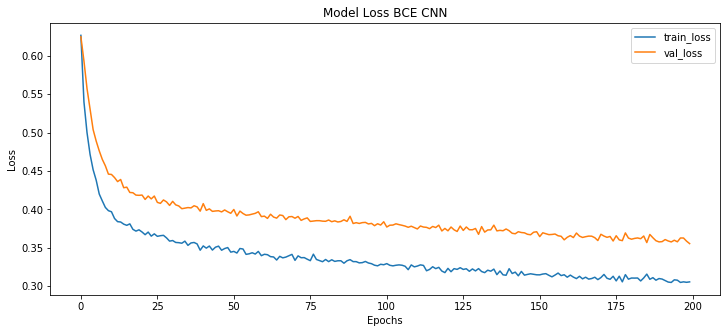

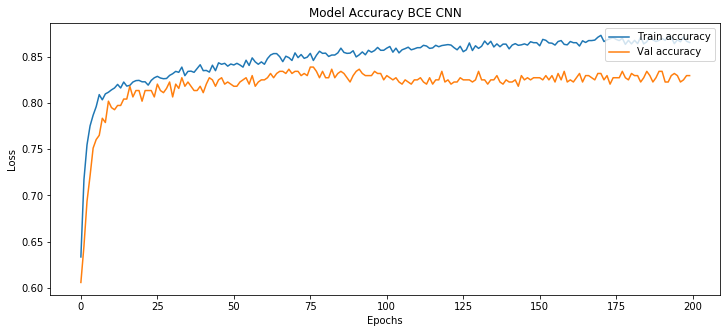

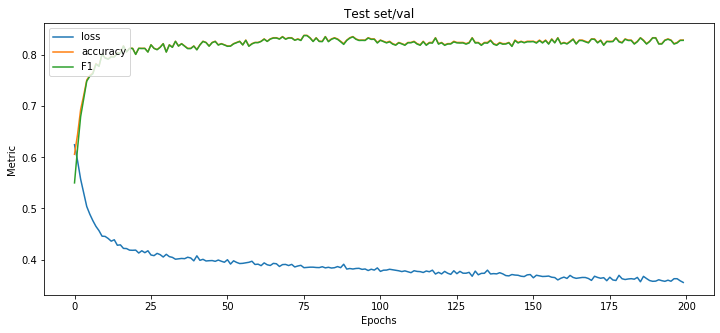

In [44]:
### meta de 7
train_model(meta, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_metadata7.hdf5')

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.915339    0.875702  0.895082     0.867632   0.85585   
Confirmed            0.786207    0.849478  0.816619     0.867632   0.85585   

                F1 micro  
False Positive  0.866528  
Confirmed       0.866528

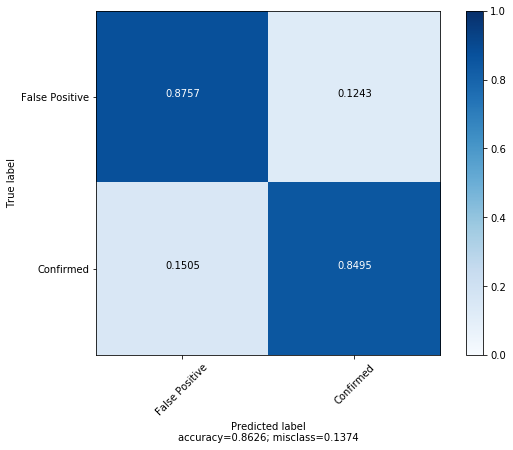

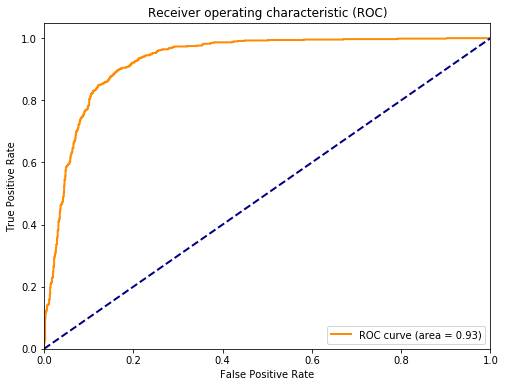

In [45]:
meta_loaded = keras.models.load_model("./models/baseline_metadata7.hdf5") #con 4 capas (64 y 128) con dropa en todo
#meta_loaded.summary()

predichos=meta_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - METADATA') #con 3 capas aumentando/double

predichos_prob = meta_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

#### FEETS
sin error

Feets ejecutado con 2500 datos
Objetos de entrenamiento: (1375, 57) (1375,)
Objetos de validación: (595, 57) (595,)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               7424      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 7,553
Trainable params: 7,553
Non-trainable params: 0
_________________________________________________________________
Train on 1237 samples, validate on 138 samples
Epoch 1/200
1237/1237 [==============================] - 1s 416us/step - loss: 0.8110 - acc: 0.4535 - val_loss: 0.6563 - val_acc: 0.5725
 - val_f1: 0.572262 
Epoch 2/200
1237/1237 [==============================] - 0s 2

1237/1237 [==============================] - 0s 28us/step - loss: 0.3756 - acc: 0.8124 - val_loss: 0.7101 - val_acc: 0.6159
 - val_f1: 0.530039 
Epoch 100/200
1237/1237 [==============================] - 0s 27us/step - loss: 0.3652 - acc: 0.8278 - val_loss: 0.7005 - val_acc: 0.6232
 - val_f1: 0.555060 
Epoch 101/200
1237/1237 [==============================] - 0s 26us/step - loss: 0.3590 - acc: 0.8254 - val_loss: 0.7180 - val_acc: 0.6159
 - val_f1: 0.543417 
Epoch 102/200
1237/1237 [==============================] - 0s 26us/step - loss: 0.3778 - acc: 0.8124 - val_loss: 0.7155 - val_acc: 0.6304
 - val_f1: 0.566492 
Epoch 103/200
1237/1237 [==============================] - 0s 27us/step - loss: 0.3750 - acc: 0.8189 - val_loss: 0.7200 - val_acc: 0.6159
 - val_f1: 0.543417 
Epoch 104/200
1237/1237 [==============================] - 0s 27us/step - loss: 0.3569 - acc: 0.8335 - val_loss: 0.7170 - val_acc: 0.6087
 - val_f1: 0.537946 
Epoch 105/200
1237/1237 [==============================] - 0

 - val_f1: 0.560536 
Epoch 151/200
1237/1237 [==============================] - 0s 24us/step - loss: 0.3284 - acc: 0.8496 - val_loss: 0.7541 - val_acc: 0.6232
 - val_f1: 0.571326 
Epoch 152/200
1237/1237 [==============================] - 0s 23us/step - loss: 0.3255 - acc: 0.8569 - val_loss: 0.7730 - val_acc: 0.6087
 - val_f1: 0.549565 
Epoch 153/200
1237/1237 [==============================] - 0s 25us/step - loss: 0.3244 - acc: 0.8488 - val_loss: 0.7778 - val_acc: 0.6304
 - val_f1: 0.566492 
Epoch 154/200
1237/1237 [==============================] - 0s 23us/step - loss: 0.3288 - acc: 0.8521 - val_loss: 0.7671 - val_acc: 0.6304
 - val_f1: 0.571976 
Epoch 155/200
1237/1237 [==============================] - 0s 25us/step - loss: 0.3242 - acc: 0.8569 - val_loss: 0.7469 - val_acc: 0.6377
 - val_f1: 0.587814 
Epoch 156/200
1237/1237 [==============================] - 0s 27us/step - loss: 0.3316 - acc: 0.8464 - val_loss: 0.7588 - val_acc: 0.6304
 - val_f1: 0.577120 
Epoch 157/200
1237/1237 [

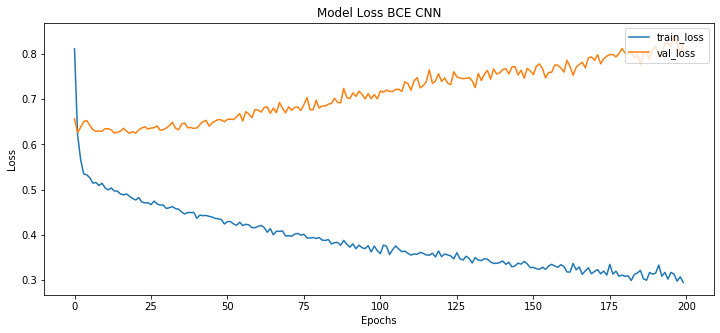

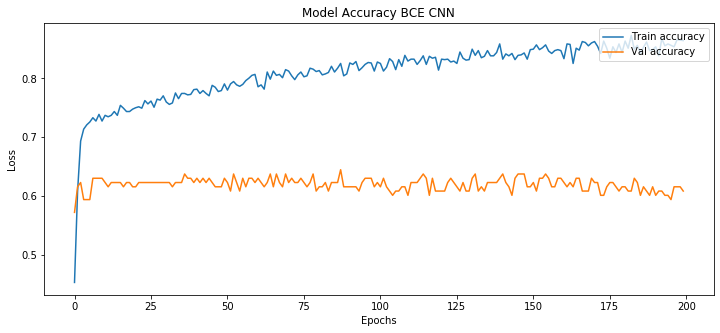

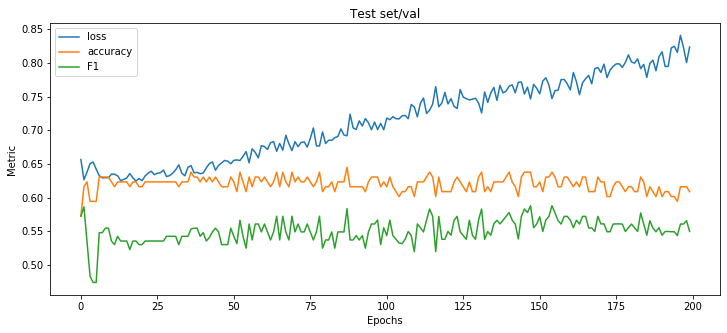

In [14]:
df = pd.read_csv("Feets_Features/ResumenFeets_sinError_seq.csv")
df = df.replace(np.inf, df.median())

x_all = df.values[:,1:]
N_F_wtE = len(x_all)
print("Feets ejecutado con",N_F_wtE,"datos")

from sklearn.preprocessing import StandardScaler, RobustScaler
x_all = StandardScaler().fit_transform(x_all)

x_train = x_all[:N_F_wtE][mask_train[:N_F_wtE]]
x_val = x_all[:N_F_wtE][mask_test[:N_F_wtE]]

y_train = y_all[:N_F_wtE][mask_train[:N_F_wtE]]
y_val = y_all[:N_F_wtE][mask_test[:N_F_wtE]]

print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

feets_ = Sequential()
feets_.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
feets_.add(Dropout(0.3)) #mientras hay pocos datos, bajar este valor
feets_.add(Dense(1, activation='sigmoid'))
feets_.summary()

train_model(feets_, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_feets_wtE.hdf5')

#o quizas RF?

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.781369    0.921525  0.845679     0.712017  0.578803   
Confirmed            0.492754    0.228188  0.311927     0.712017  0.578803   

                F1 micro  
False Positive  0.747899  
Confirmed       0.747899

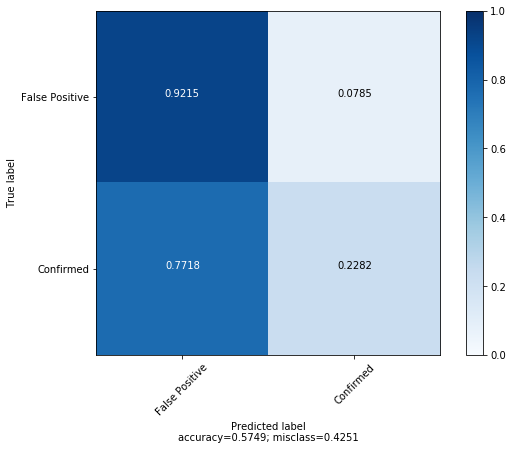

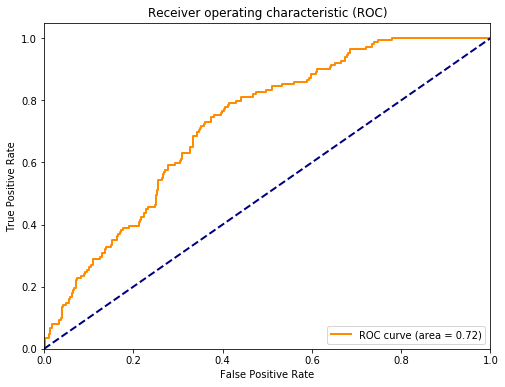

In [15]:
feets_loaded = keras.models.load_model("./models/baseline_feets_wtE.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=feets_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FEETS wt E') #con 3 capas aumentando/double

predichos_prob = feets_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

con error

Feets ejecutado con 926 datos
Objetos de entrenamiento: (496, 63) (496,)
Objetos de validación: (232, 63) (232,)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               8192      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 8,321
Trainable params: 8,321
Non-trainable params: 0
_________________________________________________________________
Train on 446 samples, validate on 50 samples
Epoch 1/200
446/446 [==============================] - 1s 2ms/step - loss: 0.9375 - acc: 0.4529 - val_loss: 0.6288 - val_acc: 0.6600
 - val_f1: 0.656566 
Epoch 2/200
446/446 [==============================] - 0s 18us/step -

 - val_f1: 0.653333 
Epoch 48/200
446/446 [==============================] - 0s 18us/step - loss: 0.4187 - acc: 0.8206 - val_loss: 0.4552 - val_acc: 0.7400
 - val_f1: 0.653333 
Epoch 49/200
446/446 [==============================] - 0s 18us/step - loss: 0.4213 - acc: 0.7758 - val_loss: 0.4542 - val_acc: 0.7400
 - val_f1: 0.653333 
Epoch 50/200
446/446 [==============================] - 0s 18us/step - loss: 0.4219 - acc: 0.8072 - val_loss: 0.4542 - val_acc: 0.7600
 - val_f1: 0.688150 
Epoch 51/200
446/446 [==============================] - 0s 17us/step - loss: 0.4206 - acc: 0.7982 - val_loss: 0.4548 - val_acc: 0.7600
 - val_f1: 0.688150 
Epoch 52/200
446/446 [==============================] - 0s 20us/step - loss: 0.4185 - acc: 0.7960 - val_loss: 0.4561 - val_acc: 0.7600
 - val_f1: 0.688150 
Epoch 53/200
446/446 [==============================] - 0s 17us/step - loss: 0.4197 - acc: 0.7870 - val_loss: 0.4578 - val_acc: 0.7600
 - val_f1: 0.688150 
Epoch 54/200
446/446 [=====================

446/446 [==============================] - 0s 20us/step - loss: 0.2949 - acc: 0.8767 - val_loss: 0.5860 - val_acc: 0.7600
 - val_f1: 0.702381 
Epoch 153/200
446/446 [==============================] - 0s 18us/step - loss: 0.2887 - acc: 0.8812 - val_loss: 0.5896 - val_acc: 0.7600
 - val_f1: 0.702381 
Epoch 154/200
446/446 [==============================] - 0s 20us/step - loss: 0.2810 - acc: 0.8677 - val_loss: 0.5915 - val_acc: 0.7600
 - val_f1: 0.702381 
Epoch 155/200
446/446 [==============================] - 0s 20us/step - loss: 0.2963 - acc: 0.8543 - val_loss: 0.5941 - val_acc: 0.7600
 - val_f1: 0.702381 
Epoch 156/200
446/446 [==============================] - 0s 18us/step - loss: 0.2724 - acc: 0.8789 - val_loss: 0.5986 - val_acc: 0.7600
 - val_f1: 0.702381 
Epoch 157/200
446/446 [==============================] - 0s 21us/step - loss: 0.2834 - acc: 0.8969 - val_loss: 0.6040 - val_acc: 0.7600
 - val_f1: 0.702381 
Epoch 158/200
446/446 [==============================] - 0s 21us/step - 

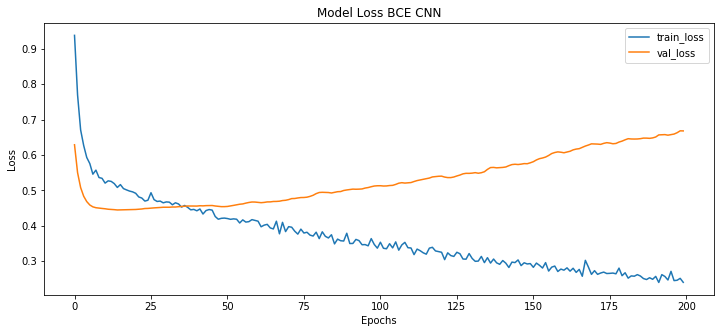

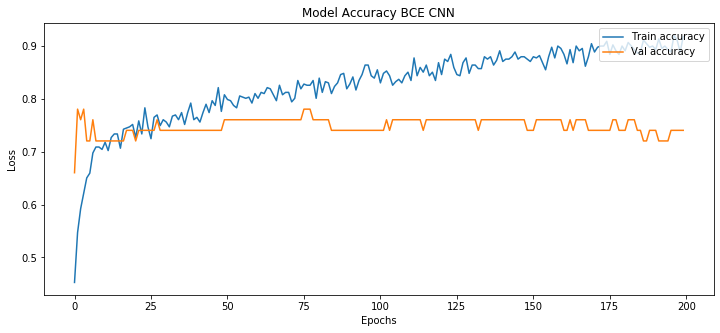

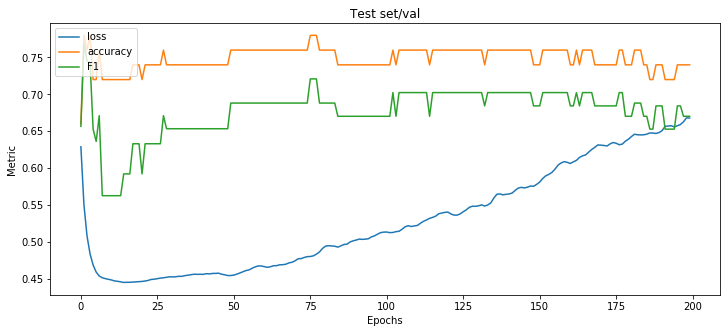

In [24]:
df = pd.read_csv("Feets_Features/ResumenFeets_conError_seq.csv")
df = df.replace(np.inf, df.median())

x_all = df.values[:,1:]
N_F_wtE = len(x_all)
print("Feets ejecutado con",N_F_wtE,"datos")

from sklearn.preprocessing import StandardScaler, RobustScaler
x_all = StandardScaler().fit_transform(x_all)

x_train = x_all[:N_F_wtE][mask_train[:N_F_wtE]]
x_val = x_all[:N_F_wtE][mask_test[:N_F_wtE]]

y_train = y_all[:N_F_wtE][mask_train[:N_F_wtE]]
y_val = y_all[:N_F_wtE][mask_test[:N_F_wtE]]

print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

feets_E = Sequential()
feets_E.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
feets_E.add(Dropout(0.5)) #mientras hay pocos datos, bajar este valor
feets_E.add(Dense(1, activation='sigmoid'))
feets_E.summary()

train_model(feets_E, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_feets_wE.hdf5')

#o quizas RF?

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.776744    0.948864  0.854220     0.700934  0.536699   
Confirmed            0.470588    0.142857  0.219178     0.700934  0.536699   

                F1 micro  
False Positive   0.75431  
Confirmed        0.75431

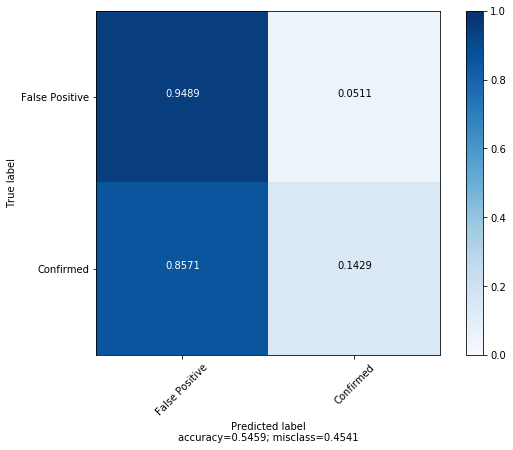

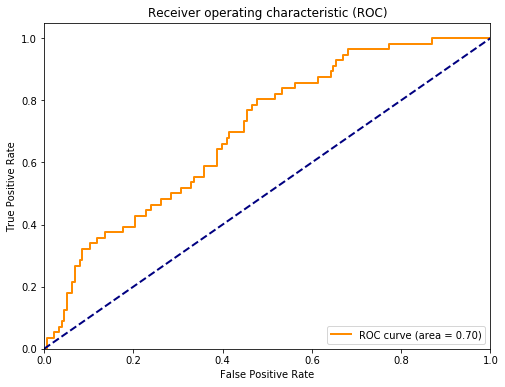

In [25]:
feets_E_loaded = keras.models.load_model("./models/baseline_feets_wE.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=feets_E_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FEETS wt E') #con 3 capas aumentando/double

predichos_prob = feets_E_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

#### Fourier

In [8]:
### ALL
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"
process_lc = np.load(folder_lc+'/cleaned/LC_kepler_processed.npy')
process_lc = process_lc/np.nanstd(process_lc, axis=1, keepdims=True) #escalar
process_lc = np.nan_to_num(process_lc) #borrar nans... arreglo variable

x_all = np.abs( np.fft.fft(process_lc, axis=1) ) #fourier
from sklearn.preprocessing import StandardScaler
x_all = StandardScaler().fit_transform(x_all)

x_train = x_all[mask_train]
x_val = x_all[mask_test]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 71427) (4339,)
Objetos de validación: (1918, 71427) (1918,)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 6s 1ms/step - loss: 4.3727 - acc: 0.6238 - val_loss: 2.5530 - val_acc: 0.6221
Epoch 2/200
3905/3905 [==============================] - 4s 1ms/step - loss: 3.1416 - acc: 0.7370 - val_loss: 5.6296 - val_acc: 0.5276
Epoch 3/200
3905/3905 [==============================] - 4s 1ms/step - loss: 1.5348 - acc: 0.8036 - val_loss: 1.2048 - val_acc: 0.5760
Epoch 4/200
3905/3905 [==============================] - 4s 1ms/step - loss: 0.7894 - acc: 0.8592 - val_loss: 1.3453 - val_acc: 0.5622
Epoch 5/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.7088 - acc: 0.8988 - val_loss: 1.2891 - val_acc: 0.5714
Epoch 6/200
3905/3905 [==============================] - 6s 1ms

Epoch 27/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.5132 - acc: 0.9644 - val_loss: 2.3981 - val_acc: 0.5714
Epoch 28/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5239 - acc: 0.9649 - val_loss: 2.1566 - val_acc: 0.5760
Epoch 29/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5193 - acc: 0.9626 - val_loss: 2.1800 - val_acc: 0.5853
Epoch 30/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5142 - acc: 0.9654 - val_loss: 2.2128 - val_acc: 0.5806
Epoch 31/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5076 - acc: 0.9667 - val_loss: 2.2565 - val_acc: 0.5899
Epoch 32/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5164 - acc: 0.9644 - val_loss: 1.8842 - val_acc: 0.5991
Epoch 33/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5139 - acc: 0.9644 - val_loss: 2.3701 - val_acc: 0.5783
Epoch 34/200
3905/3905 [========================

Epoch 62/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5085 - acc: 0.9667 - val_loss: 2.4729 - val_acc: 0.5737
Epoch 63/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5003 - acc: 0.9654 - val_loss: 2.2893 - val_acc: 0.5829
Epoch 64/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.5125 - acc: 0.9659 - val_loss: 2.5108 - val_acc: 0.6060
Epoch 65/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5015 - acc: 0.9667 - val_loss: 2.5074 - val_acc: 0.6083
Epoch 66/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5027 - acc: 0.9652 - val_loss: 2.3158 - val_acc: 0.5922
Epoch 67/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5020 - acc: 0.9667 - val_loss: 2.5325 - val_acc: 0.5829
Epoch 68/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5003 - acc: 0.9677 - val_loss: 2.1868 - val_acc: 0.6014
Epoch 69/200
3905/3905 [========================

Epoch 97/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4977 - acc: 0.9657 - val_loss: 2.7719 - val_acc: 0.5853
Epoch 98/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4995 - acc: 0.9670 - val_loss: 2.9046 - val_acc: 0.5945
Epoch 99/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4933 - acc: 0.9672 - val_loss: 3.0755 - val_acc: 0.5876
Epoch 100/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.5028 - acc: 0.9649 - val_loss: 2.8369 - val_acc: 0.5968
Epoch 101/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.5021 - acc: 0.9657 - val_loss: 2.5229 - val_acc: 0.6014
Epoch 102/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4901 - acc: 0.9659 - val_loss: 2.6970 - val_acc: 0.5760
Epoch 103/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5024 - acc: 0.9667 - val_loss: 3.1306 - val_acc: 0.5714
Epoch 104/200
3905/3905 [===================

3905/3905 [==============================] - 6s 1ms/step - loss: 0.4819 - acc: 0.9667 - val_loss: 4.0397 - val_acc: 0.5806
Epoch 166/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.5153 - acc: 0.9634 - val_loss: 3.5126 - val_acc: 0.5876
Epoch 167/200
3905/3905 [==============================] - 6s 1ms/step - loss: 0.4935 - acc: 0.9672 - val_loss: 4.3863 - val_acc: 0.5876
Epoch 168/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4945 - acc: 0.9659 - val_loss: 4.2090 - val_acc: 0.5922
Epoch 169/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.4801 - acc: 0.9672 - val_loss: 4.4052 - val_acc: 0.5737
Epoch 170/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5464 - acc: 0.9595 - val_loss: 3.9035 - val_acc: 0.6244
Epoch 171/200
3905/3905 [==============================] - 5s 1ms/step - loss: 0.5162 - acc: 0.9639 - val_loss: 3.8596 - val_acc: 0.5806
Epoch 172/200
3905/3905 [==============================

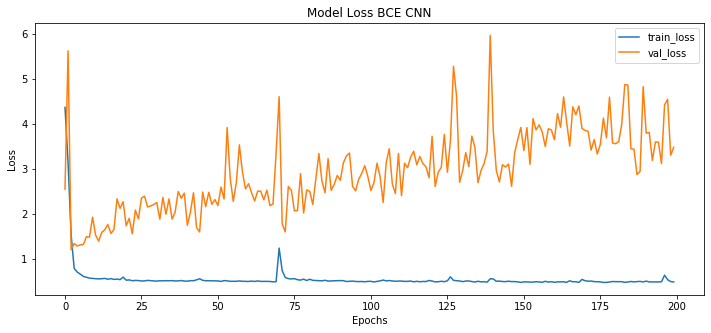

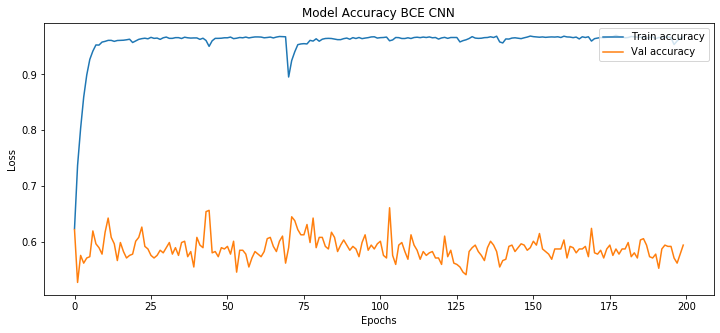

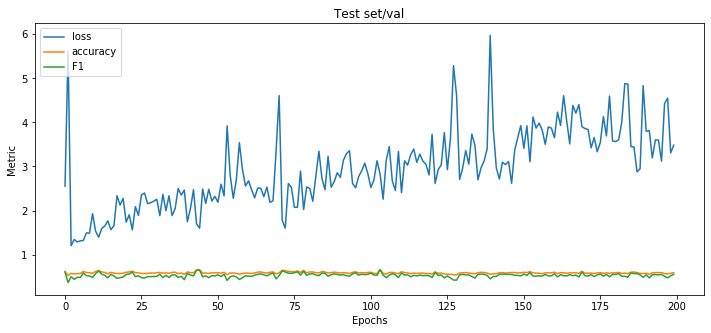

In [9]:
all_lc = Sequential()
all_lc.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
all_lc.add(Dropout(0.5))
all_lc.add(Dense(1, activation='sigmoid'))

train_model(all_lc, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/aux.hdf5')

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.729045    0.899759  0.805456      0.69293  0.644633   
Confirmed            0.670185    0.378539  0.483810      0.69293  0.644633   

                F1 micro  
False Positive  0.717414  
Confirmed       0.717414

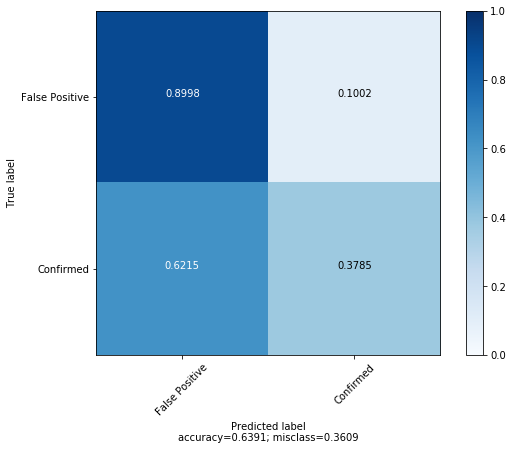

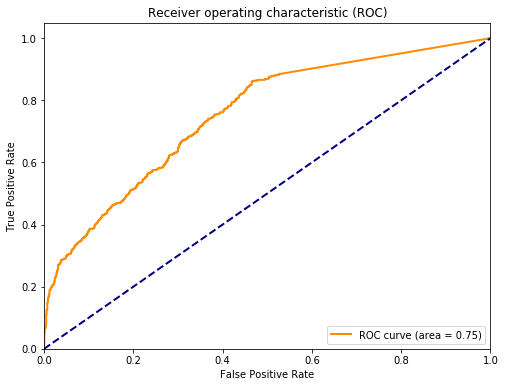

In [10]:
all_lc = keras.models.load_model("./models/aux.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=all_lc.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FOURIER UNFOLDED') #con 3 capas aumentando/double

predichos_prob = all_lc.predict(x_val)
plot_ROC(y_val, predichos_prob)

#### Fourier + PCA

#### 32

In [50]:
x_all=np.load("../obj4/LC_features/FourierPCA_71427T_32D.npy")

x_train = x_all[mask_train]
x_val = x_all[mask_test]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

f = Sequential()
f.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
f.add(Dropout(0.5))
f.add(Dense(1, activation='sigmoid'))

train_model(f, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_funfolded.hdf5')

Objetos de entrenamiento: (4339, 32) (4339,)
Objetos de validación: (1918, 32) (1918,)


Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.771982    0.830794  0.800309     0.725126  0.692857   
Confirmed            0.633681    0.543964  0.585405     0.725126  0.692857   

                F1 micro  
False Positive  0.730448  
Confirmed       0.730448

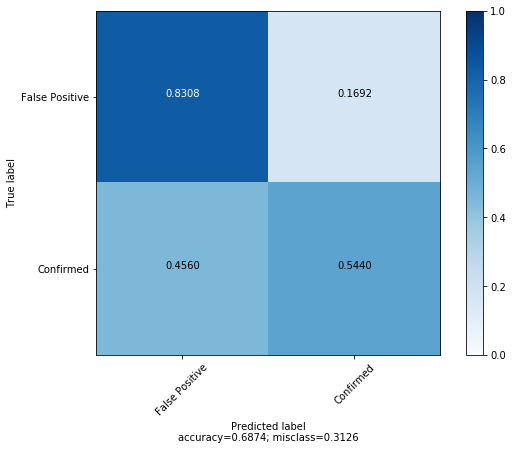

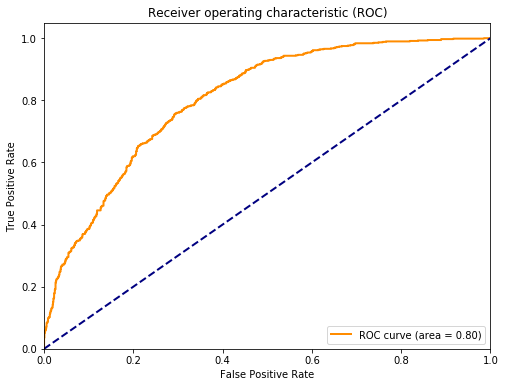

In [51]:
f_loaded = keras.models.load_model("./models/baseline_funfolded.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=f_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FOURIER UNFOLDED') #con 3 capas aumentando/double

predichos_prob = f_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

#### 16

Objetos de entrenamiento: (4339, 16) (4339,)
Objetos de validación: (1918, 16) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 141us/step - loss: 4.2266 - acc: 0.5076 - val_loss: 1.1304 - val_acc: 0.5622
 - val_f1: 0.497256 
Epoch 2/200
3905/3905 [==============================] - 0s 27us/step - loss: 2.4056 - acc: 0.6228 - val_loss: 1.2179 - val_acc: 0.6037
 - val_f1: 0.564623 
Epoch 3/200
3905/3905 [==============================] - 0s 26us/step - loss: 2.0801 - acc: 0.6284 - val_loss: 1.1147 - val_acc: 0.6359
 - val_f1: 0.627852 
Epoch 4/200
3905/3905 [==============================] - 0s 26us/step - loss: 1.6069 - acc: 0.6484 - val_loss: 1.1427 - val_acc: 0.6014
 - val_f1: 0.558681 
Epoch 5/200
3905/3905 [==============================] - 0s 27us/step - loss: 1.4318 - acc: 0.6435 - val_loss: 1.1874 - val_acc: 0.5853
 - val_f1: 0.525510 
Epoch 6/200
3905/3905 [==============================] - 0s 28us/step - loss: 1.

3905/3905 [==============================] - 0s 25us/step - loss: 0.5425 - acc: 0.6965 - val_loss: 0.6113 - val_acc: 0.5945
 - val_f1: 0.545852 
Epoch 53/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.5381 - acc: 0.6901 - val_loss: 0.6220 - val_acc: 0.5945
 - val_f1: 0.545852 
Epoch 54/200
3905/3905 [==============================] - 0s 25us/step - loss: 0.5382 - acc: 0.6983 - val_loss: 0.6138 - val_acc: 0.6037
 - val_f1: 0.560532 
Epoch 55/200
3905/3905 [==============================] - 0s 27us/step - loss: 0.5404 - acc: 0.6922 - val_loss: 0.6263 - val_acc: 0.5945
 - val_f1: 0.537773 
Epoch 56/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.5416 - acc: 0.6922 - val_loss: 0.6168 - val_acc: 0.5945
 - val_f1: 0.539456 
Epoch 57/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.5408 - acc: 0.6922 - val_loss: 0.6186 - val_acc: 0.5853
 - val_f1: 0.523717 
Epoch 58/200
3905/3905 [==============================] - 0s 26us

3905/3905 [==============================] - 0s 25us/step - loss: 0.5241 - acc: 0.6973 - val_loss: 0.6128 - val_acc: 0.6014
 - val_f1: 0.565324 
Epoch 105/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.5250 - acc: 0.6965 - val_loss: 0.5993 - val_acc: 0.6544
 - val_f1: 0.644029 
Epoch 106/200
3905/3905 [==============================] - 0s 27us/step - loss: 0.5242 - acc: 0.6994 - val_loss: 0.6026 - val_acc: 0.6452
 - val_f1: 0.630659 
Epoch 107/200
3905/3905 [==============================] - 0s 24us/step - loss: 0.5246 - acc: 0.7063 - val_loss: 0.6120 - val_acc: 0.6083
 - val_f1: 0.568366 
Epoch 108/200
3905/3905 [==============================] - 0s 28us/step - loss: 0.5192 - acc: 0.7032 - val_loss: 0.6222 - val_acc: 0.6244
 - val_f1: 0.596062 
Epoch 109/200
3905/3905 [==============================] - 0s 23us/step - loss: 0.5254 - acc: 0.7096 - val_loss: 0.6180 - val_acc: 0.6083
 - val_f1: 0.573477 
Epoch 110/200
3905/3905 [==============================] - 0

 - val_f1: 0.616657 
Epoch 156/200
3905/3905 [==============================] - 0s 25us/step - loss: 0.5172 - acc: 0.7106 - val_loss: 0.6087 - val_acc: 0.6406
 - val_f1: 0.618655 
Epoch 157/200
3905/3905 [==============================] - 0s 25us/step - loss: 0.5127 - acc: 0.7137 - val_loss: 0.6122 - val_acc: 0.6544
 - val_f1: 0.640927 
Epoch 158/200
3905/3905 [==============================] - 0s 27us/step - loss: 0.5140 - acc: 0.7083 - val_loss: 0.6278 - val_acc: 0.6336
 - val_f1: 0.607998 
Epoch 159/200
3905/3905 [==============================] - 0s 27us/step - loss: 0.5162 - acc: 0.7124 - val_loss: 0.6071 - val_acc: 0.6406
 - val_f1: 0.625862 
Epoch 160/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.5171 - acc: 0.7091 - val_loss: 0.6286 - val_acc: 0.6290
 - val_f1: 0.603068 
Epoch 161/200
3905/3905 [==============================] - 0s 25us/step - loss: 0.5159 - acc: 0.7073 - val_loss: 0.6115 - val_acc: 0.6198
 - val_f1: 0.591106 
Epoch 162/200
3905/3905 [

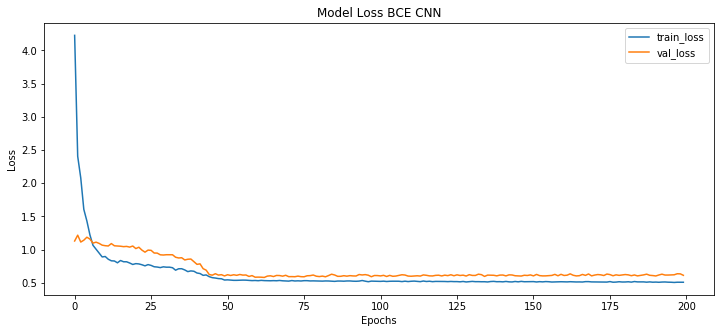

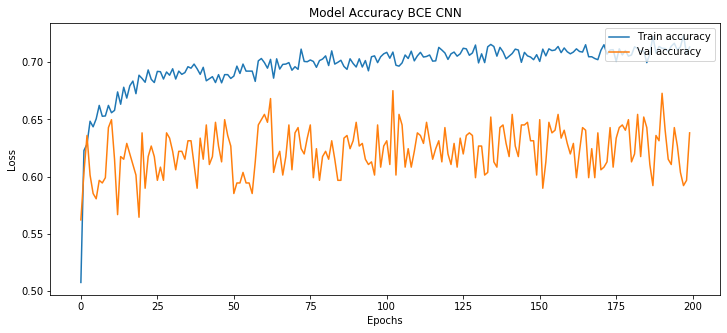

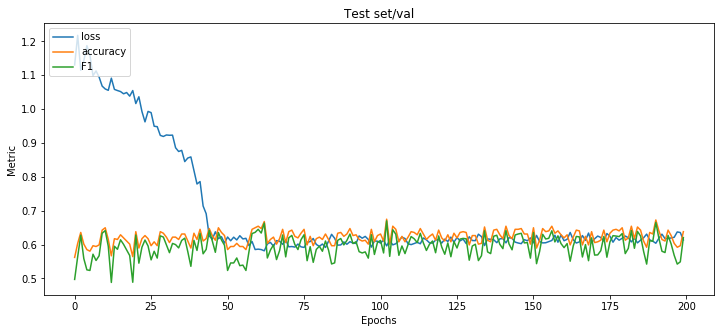

In [14]:
x_all=np.load("../obj4/LC_features/FourierPCA_71427T_32D.npy")
x_all = x_all[:,:16]

x_train = x_all[mask_train]
x_val = x_all[mask_test]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

f = Sequential()
f.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
f.add(Dropout(0.5))
f.add(Dense(1, activation='sigmoid'))

train_model(f, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_funfolded.hdf5')

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.789916    0.753809  0.771440     0.712113  0.686649   
Confirmed            0.578297    0.627422  0.601858     0.712113  0.686649   

                F1 micro  
False Positive  0.709593  
Confirmed       0.709593

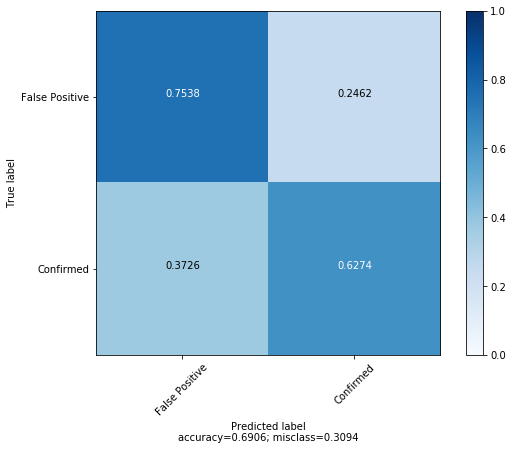

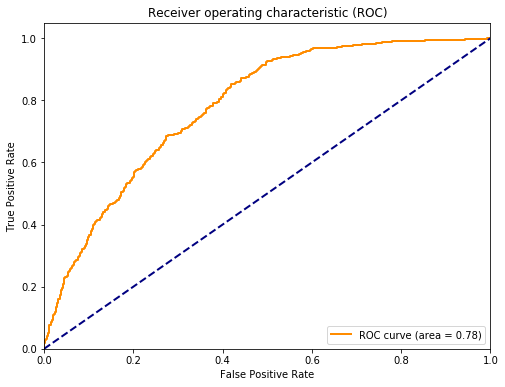

In [15]:
f_loaded = keras.models.load_model("./models/baseline_funfolded.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=f_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FOURIER UNFOLDED') #con 3 capas aumentando/double

predichos_prob = f_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

#### 30x30x2

Objetos de entrenamiento: (4339, 1800) (4339,)
Objetos de validación: (1918, 1800) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 287us/step - loss: 2.0407 - acc: 0.6115 - val_loss: 1.4918 - val_acc: 0.6267
Epoch 2/200
3905/3905 [==============================] - 0s 65us/step - loss: 0.9072 - acc: 0.7844 - val_loss: 1.4419 - val_acc: 0.6290
Epoch 3/200
3905/3905 [==============================] - 0s 66us/step - loss: 0.6074 - acc: 0.8407 - val_loss: 1.4163 - val_acc: 0.6590
Epoch 4/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.4144 - acc: 0.8822 - val_loss: 1.4604 - val_acc: 0.6498
Epoch 5/200
3905/3905 [==============================] - 0s 62us/step - loss: 0.3129 - acc: 0.9160 - val_loss: 1.4953 - val_acc: 0.6452
Epoch 6/200
3905/3905 [==============================] - 0s 59us/step - loss: 0.2516 - acc: 0.9309 - val_loss: 1.5501 - val_acc: 0.6406
Epoch 7/200
3905/3905 [======================

Epoch 35/200
3905/3905 [==============================] - 0s 62us/step - loss: 0.0555 - acc: 0.9923 - val_loss: 2.0833 - val_acc: 0.6221
Epoch 36/200
3905/3905 [==============================] - 0s 59us/step - loss: 0.0525 - acc: 0.9921 - val_loss: 2.0921 - val_acc: 0.6221
Epoch 37/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0509 - acc: 0.9939 - val_loss: 2.1257 - val_acc: 0.6152
Epoch 38/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0535 - acc: 0.9931 - val_loss: 2.1269 - val_acc: 0.6106
Epoch 39/200
3905/3905 [==============================] - 0s 63us/step - loss: 0.0540 - acc: 0.9923 - val_loss: 2.1904 - val_acc: 0.6060
Epoch 40/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0544 - acc: 0.9910 - val_loss: 2.1918 - val_acc: 0.6175
Epoch 41/200
3905/3905 [==============================] - 0s 58us/step - loss: 0.0607 - acc: 0.9921 - val_loss: 2.1807 - val_acc: 0.6152
Epoch 42/200
3905/3905 [=================

3905/3905 [==============================] - 0s 63us/step - loss: 0.0458 - acc: 0.9923 - val_loss: 2.9578 - val_acc: 0.6152
Epoch 104/200
3905/3905 [==============================] - 0s 65us/step - loss: 0.0498 - acc: 0.9923 - val_loss: 3.0031 - val_acc: 0.5991
Epoch 105/200
3905/3905 [==============================] - 0s 62us/step - loss: 0.0429 - acc: 0.9944 - val_loss: 3.0003 - val_acc: 0.5945
Epoch 106/200
3905/3905 [==============================] - 0s 66us/step - loss: 0.0449 - acc: 0.9931 - val_loss: 2.9902 - val_acc: 0.5991
Epoch 107/200
3905/3905 [==============================] - 0s 63us/step - loss: 0.0388 - acc: 0.9939 - val_loss: 3.0319 - val_acc: 0.5991
Epoch 108/200
3905/3905 [==============================] - 0s 62us/step - loss: 0.0398 - acc: 0.9933 - val_loss: 3.0313 - val_acc: 0.6060
Epoch 109/200
3905/3905 [==============================] - 0s 63us/step - loss: 0.0375 - acc: 0.9939 - val_loss: 3.1652 - val_acc: 0.5968
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 62us/step - loss: 0.0543 - acc: 0.9933 - val_loss: 3.3353 - val_acc: 0.6175
Epoch 172/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0450 - acc: 0.9918 - val_loss: 3.4138 - val_acc: 0.6198
Epoch 173/200
3905/3905 [==============================] - 0s 61us/step - loss: 0.0551 - acc: 0.9918 - val_loss: 3.4591 - val_acc: 0.6175
Epoch 174/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0416 - acc: 0.9933 - val_loss: 3.4744 - val_acc: 0.6129
Epoch 175/200
3905/3905 [==============================] - 0s 59us/step - loss: 0.0507 - acc: 0.9926 - val_loss: 3.4371 - val_acc: 0.6175
Epoch 176/200
3905/3905 [==============================] - 0s 60us/step - loss: 0.0445 - acc: 0.9923 - val_loss: 3.6944 - val_acc: 0.5899
Epoch 177/200
3905/3905 [==============================] - 0s 66us/step - loss: 0.0434 - acc: 0.9923 - val_loss: 3.6906 - val_acc: 0.5853
Epoch 178/200
3905/3905 [=======================

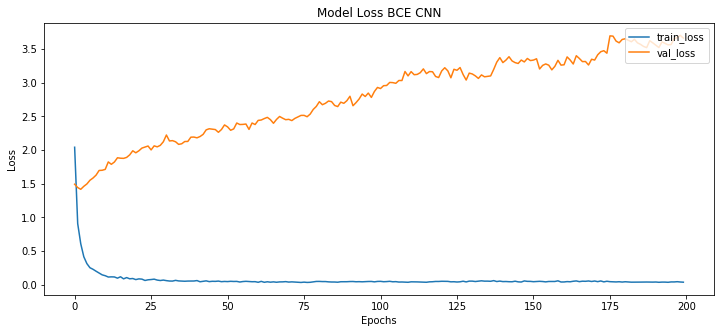

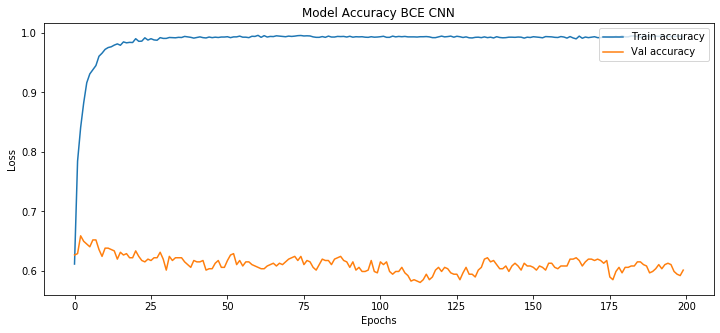

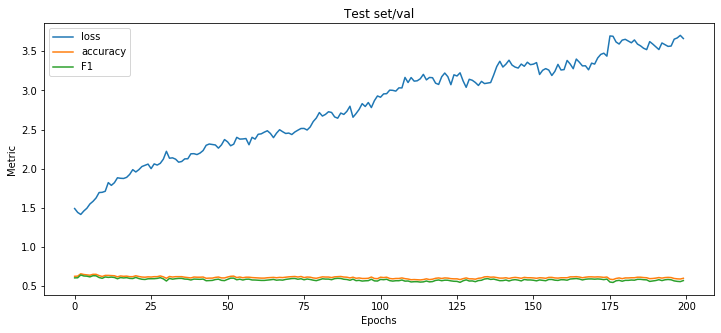

In [10]:
x_all=np.load("../obj4/LC_features/FourierPCA_71427T_1800D.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

f2 = Sequential()
f2.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
f2.add(Dropout(0.5))
f2.add(Dense(1, activation='sigmoid'))

train_model(f2, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_funfolded2.hdf5')

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.776646    0.794707  0.785573     0.716441   0.68677   
Confirmed            0.601246    0.575261  0.587966     0.716441   0.68677   

                F1 micro  
False Positive  0.717935  
Confirmed       0.717935

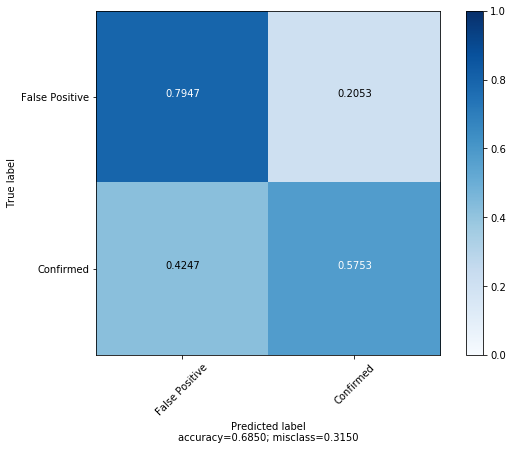

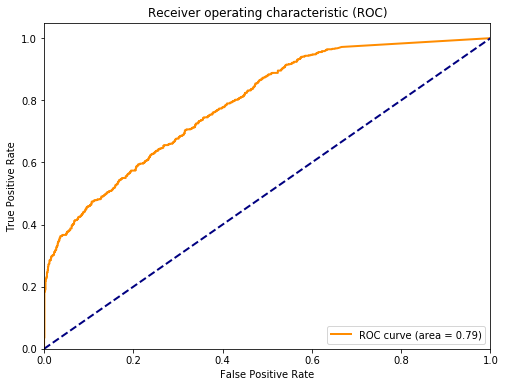

In [17]:
f2_loaded = keras.models.load_model("./models/baseline_funfolded2.hdf5") #con 4 capas (64 y 128) con dropa en todo
#f2_loaded.summary()

predichos=f2_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FOURIER UNFOLDED') #con 3 capas aumentando/double

predichos_prob = f2_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

## Fold experiments
#### All measurements (T=300)

Objetos de entrenamiento: (4339, 300) (4339,)
Objetos de validación: (1918, 300) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 229us/step - loss: 0.6774 - acc: 0.6510 - val_loss: 0.5552 - val_acc: 0.7488
 - val_f1: 0.746803 
Epoch 2/200
3905/3905 [==============================] - 0s 58us/step - loss: 0.5211 - acc: 0.7439 - val_loss: 0.5257 - val_acc: 0.7465
 - val_f1: 0.744586 
Epoch 3/200
3905/3905 [==============================] - 0s 73us/step - loss: 0.4645 - acc: 0.7721 - val_loss: 0.5246 - val_acc: 0.7627
 - val_f1: 0.758204 
Epoch 4/200
3905/3905 [==============================] - 0s 55us/step - loss: 0.4333 - acc: 0.7992 - val_loss: 0.5162 - val_acc: 0.7581
 - val_f1: 0.754677 
Epoch 5/200
3905/3905 [==============================] - 0s 54us/step - loss: 0.4026 - acc: 0.8241 - val_loss: 0.5087 - val_acc: 0.7535
 - val_f1: 0.750530 
Epoch 6/200
3905/3905 [==============================] - 0s 54us/step - loss: 

3905/3905 [==============================] - 0s 52us/step - loss: 0.0991 - acc: 0.9680 - val_loss: 0.7509 - val_acc: 0.7535
 - val_f1: 0.749724 
Epoch 53/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.0934 - acc: 0.9682 - val_loss: 0.7409 - val_acc: 0.7535
 - val_f1: 0.750530 
Epoch 54/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.0991 - acc: 0.9688 - val_loss: 0.7514 - val_acc: 0.7627
 - val_f1: 0.758799 
Epoch 55/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.0946 - acc: 0.9667 - val_loss: 0.7501 - val_acc: 0.7581
 - val_f1: 0.754402 
Epoch 56/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.0922 - acc: 0.9680 - val_loss: 0.7436 - val_acc: 0.7604
 - val_f1: 0.756311 
Epoch 57/200
3905/3905 [==============================] - 0s 53us/step - loss: 0.0912 - acc: 0.9688 - val_loss: 0.7690 - val_acc: 0.7558
 - val_f1: 0.750672 
Epoch 58/200
3905/3905 [==============================] - 0s 50us

3905/3905 [==============================] - 0s 48us/step - loss: 0.0603 - acc: 0.9803 - val_loss: 1.0621 - val_acc: 0.7604
 - val_f1: 0.756011 
Epoch 105/200
3905/3905 [==============================] - 0s 52us/step - loss: 0.0652 - acc: 0.9798 - val_loss: 1.0627 - val_acc: 0.7627
 - val_f1: 0.758507 
Epoch 106/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.0621 - acc: 0.9777 - val_loss: 1.0671 - val_acc: 0.7673
 - val_f1: 0.762899 
Epoch 107/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.0581 - acc: 0.9808 - val_loss: 1.0293 - val_acc: 0.7558
 - val_f1: 0.751920 
Epoch 108/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.0575 - acc: 0.9821 - val_loss: 1.0753 - val_acc: 0.7627
 - val_f1: 0.758507 
Epoch 109/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.0653 - acc: 0.9777 - val_loss: 1.0767 - val_acc: 0.7650
 - val_f1: 0.760998 
Epoch 110/200
3905/3905 [==============================] - 0

 - val_f1: 0.748488 
Epoch 156/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.0539 - acc: 0.9816 - val_loss: 1.3886 - val_acc: 0.7512
 - val_f1: 0.745968 
Epoch 157/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.0498 - acc: 0.9816 - val_loss: 1.4310 - val_acc: 0.7396
 - val_f1: 0.732471 
Epoch 158/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.0435 - acc: 0.9857 - val_loss: 1.3905 - val_acc: 0.7512
 - val_f1: 0.745261 
Epoch 159/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.0469 - acc: 0.9844 - val_loss: 1.4302 - val_acc: 0.7465
 - val_f1: 0.739774 
Epoch 160/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.0468 - acc: 0.9844 - val_loss: 1.4536 - val_acc: 0.7488
 - val_f1: 0.742335 
Epoch 161/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.0468 - acc: 0.9839 - val_loss: 1.4309 - val_acc: 0.7604
 - val_f1: 0.755376 
Epoch 162/200
3905/3905 [

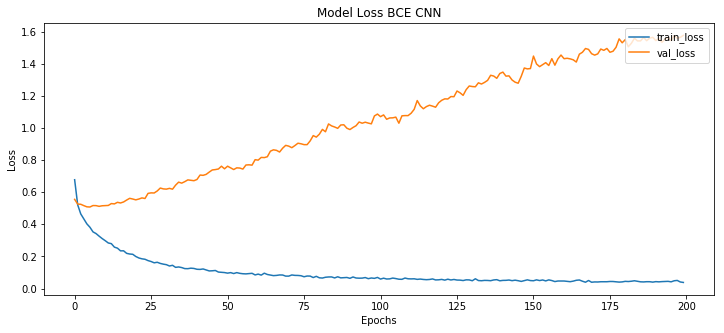

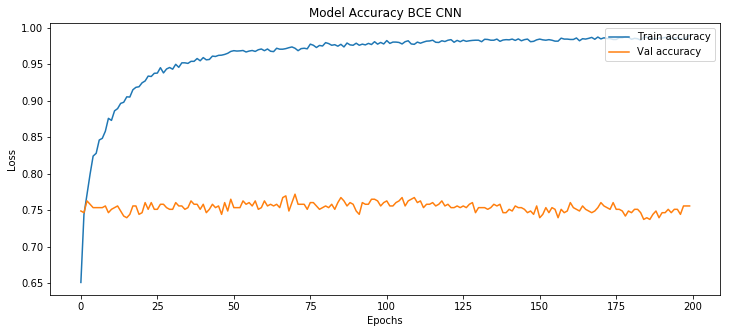

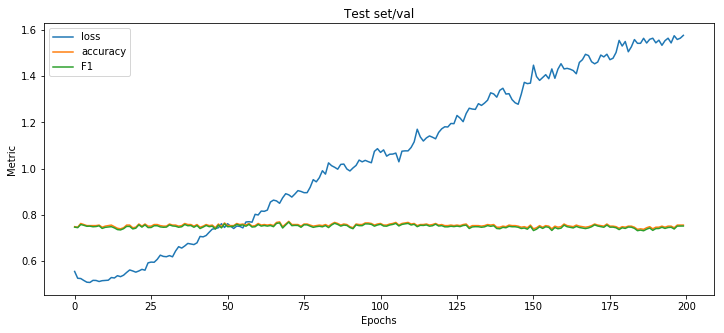

In [12]:
T = 300
x_all = np.load("../obj4/data/LC_global_%dT.npy"%T)
x_all = x_all/x_all.std(axis=1, keepdims=True)

#add time x_all2 = np.load("../obj4/data/Time_global_%dT.npy"%T)
#x_all = np.concatenate([x_all,x_all2], axis=-1)


x_train = x_all[mask_train]
x_val = x_all[mask_test]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

foldT = Sequential()
foldT.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
foldT.add(Dropout(0.5))
foldT.add(Dense(1, activation='sigmoid'))

train_model(foldT, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_foldT.hdf5')

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.764554  0.785714  0.835138     0.785751       0.835474   
Confirmed       0.764554  0.785714  0.693969     0.785751       0.693452   

                Recall raw  
False Positive    0.834804  
Confirmed         0.694486

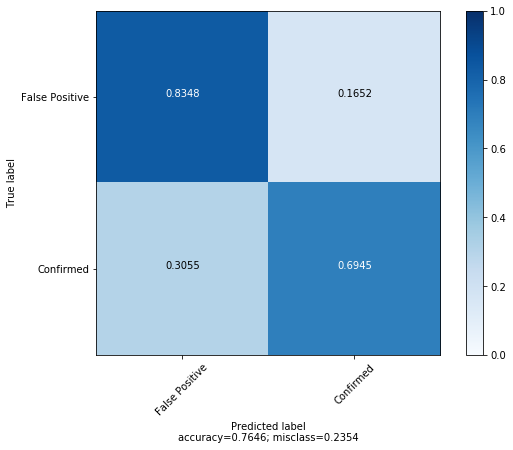

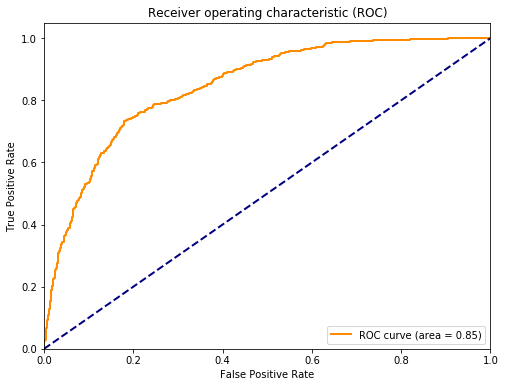

In [13]:
foldT_loaded = keras.models.load_model("./models/baseline_foldT.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=foldT_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = foldT_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

### Fourier+PCA(32 or 16)

Objetos de entrenamiento: (4339, 16) (4339,)
Objetos de validación: (1918, 16) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 0s 98us/step - loss: 0.9443 - acc: 0.5636 - val_loss: 0.6230 - val_acc: 0.6429
 - val_f1: 0.629299 
Epoch 2/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.6752 - acc: 0.6656 - val_loss: 0.5804 - val_acc: 0.7097
 - val_f1: 0.706379 
Epoch 3/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.6047 - acc: 0.6968 - val_loss: 0.5593 - val_acc: 0.7396
 - val_f1: 0.734027 
Epoch 4/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.6036 - acc: 0.6973 - val_loss: 0.5466 - val_acc: 0.7327
 - val_f1: 0.727511 
Epoch 5/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.5681 - acc: 0.7188 - val_loss: 0.5403 - val_acc: 0.7442
 - val_f1: 0.740368 
Epoch 6/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.5

3905/3905 [==============================] - 0s 28us/step - loss: 0.4311 - acc: 0.8028 - val_loss: 0.4921 - val_acc: 0.7627
 - val_f1: 0.755367 
Epoch 53/200
3905/3905 [==============================] - 0s 24us/step - loss: 0.4307 - acc: 0.7972 - val_loss: 0.4780 - val_acc: 0.7696
 - val_f1: 0.764785 
Epoch 54/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.4357 - acc: 0.7954 - val_loss: 0.4785 - val_acc: 0.7742
 - val_f1: 0.769489 
Epoch 55/200
3905/3905 [==============================] - 0s 24us/step - loss: 0.4282 - acc: 0.8023 - val_loss: 0.4787 - val_acc: 0.7719
 - val_f1: 0.766655 
Epoch 56/200
3905/3905 [==============================] - 0s 25us/step - loss: 0.4336 - acc: 0.7913 - val_loss: 0.4803 - val_acc: 0.7650
 - val_f1: 0.758700 
Epoch 57/200
3905/3905 [==============================] - 0s 27us/step - loss: 0.4344 - acc: 0.7969 - val_loss: 0.4867 - val_acc: 0.7650
 - val_f1: 0.758326 
Epoch 58/200
3905/3905 [==============================] - 0s 26us

3905/3905 [==============================] - 0s 24us/step - loss: 0.4170 - acc: 0.8085 - val_loss: 0.4770 - val_acc: 0.7696
 - val_f1: 0.762686 
Epoch 105/200
3905/3905 [==============================] - 0s 25us/step - loss: 0.4060 - acc: 0.8120 - val_loss: 0.4726 - val_acc: 0.7788
 - val_f1: 0.773565 
Epoch 106/200
3905/3905 [==============================] - 0s 25us/step - loss: 0.4083 - acc: 0.8136 - val_loss: 0.4740 - val_acc: 0.7627
 - val_f1: 0.756518 
Epoch 107/200
3905/3905 [==============================] - 0s 25us/step - loss: 0.4103 - acc: 0.8108 - val_loss: 0.4648 - val_acc: 0.7765
 - val_f1: 0.771687 
Epoch 108/200
3905/3905 [==============================] - 0s 24us/step - loss: 0.4086 - acc: 0.8085 - val_loss: 0.4647 - val_acc: 0.7811
 - val_f1: 0.776695 
Epoch 109/200
3905/3905 [==============================] - 0s 27us/step - loss: 0.4095 - acc: 0.8110 - val_loss: 0.4746 - val_acc: 0.7650
 - val_f1: 0.757940 
Epoch 110/200
3905/3905 [==============================] - 0

 - val_f1: 0.773235 
Epoch 156/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.4020 - acc: 0.8108 - val_loss: 0.4780 - val_acc: 0.7719
 - val_f1: 0.764867 
Epoch 157/200
3905/3905 [==============================] - 0s 24us/step - loss: 0.3959 - acc: 0.8174 - val_loss: 0.4698 - val_acc: 0.7696
 - val_f1: 0.763064 
Epoch 158/200
3905/3905 [==============================] - 0s 27us/step - loss: 0.3938 - acc: 0.8241 - val_loss: 0.4675 - val_acc: 0.7765
 - val_f1: 0.770702 
Epoch 159/200
3905/3905 [==============================] - 0s 28us/step - loss: 0.3952 - acc: 0.8213 - val_loss: 0.4719 - val_acc: 0.7742
 - val_f1: 0.768162 
Epoch 160/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.3973 - acc: 0.8220 - val_loss: 0.4675 - val_acc: 0.7788
 - val_f1: 0.773235 
Epoch 161/200
3905/3905 [==============================] - 0s 27us/step - loss: 0.3975 - acc: 0.8169 - val_loss: 0.4687 - val_acc: 0.7811
 - val_f1: 0.775762 
Epoch 162/200
3905/3905 [

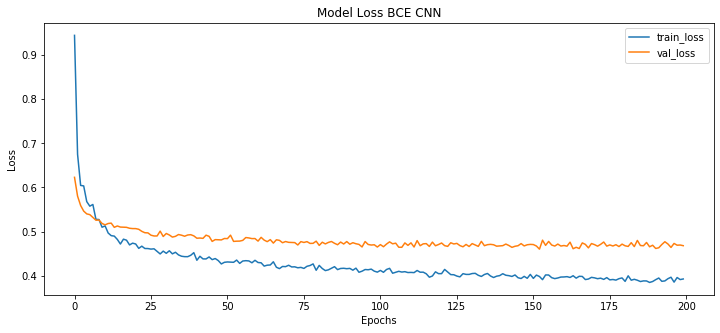

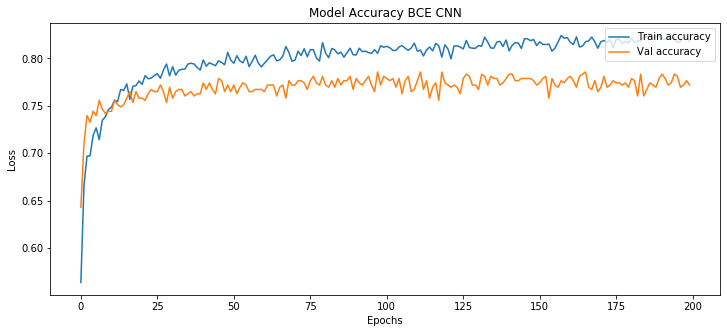

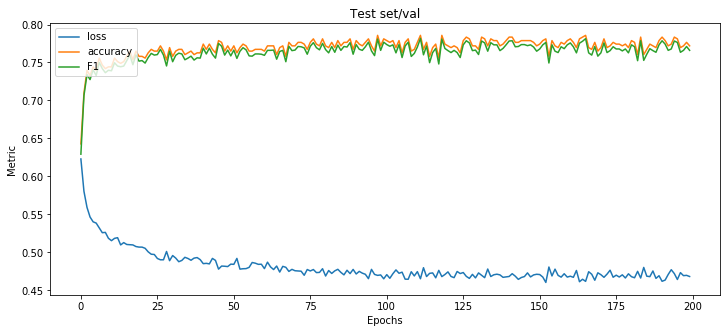

In [10]:
x_all=np.load("../obj4/LC_features/FourierPCA_300T_32D.npy")
x_all = x_all[:,:16]

x_train = x_all[mask_train]
x_val = x_all[mask_test]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

foldPCA = Sequential()
foldPCA.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
foldPCA.add(Dropout(0.5))
foldPCA.add(Dense(1, activation='sigmoid'))

train_model(foldPCA, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_foldPCA.hdf5')

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.845476    0.846832  0.846154     0.799722  0.779793   
Confirmed            0.714499    0.712370  0.713433     0.799722  0.779793   

                F1 micro  
False Positive  0.799791  
Confirmed       0.799791

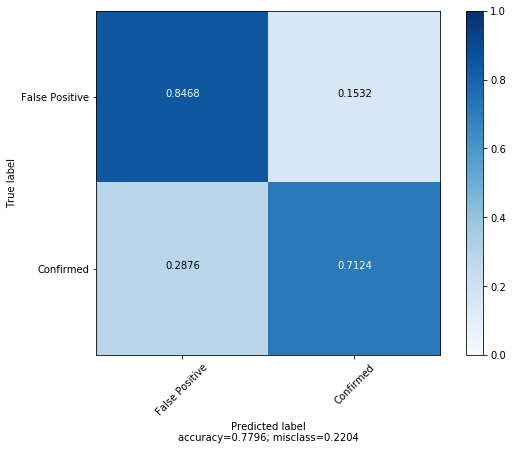

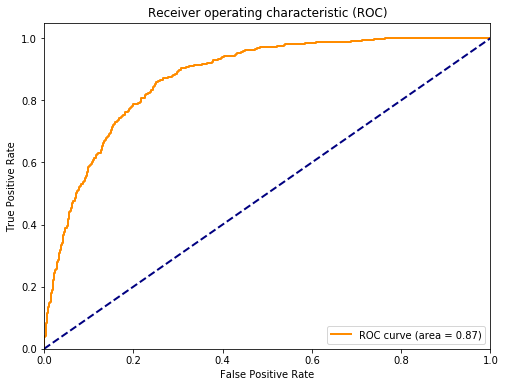

In [11]:
foldPCA_loaded = keras.models.load_model("./models/baseline_foldPCA.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=foldPCA_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = foldPCA_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

Objetos de entrenamiento: (4339, 16) (4339,)
Objetos de validación: (1918, 16) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 360us/step - loss: 0.6780 - acc: 0.6346 - val_loss: 0.6975 - val_acc: 0.5184
Epoch 2/200
3905/3905 [==============================] - 0s 17us/step - loss: 0.6552 - acc: 0.6412 - val_loss: 0.7169 - val_acc: 0.5184
Epoch 3/200
3905/3905 [==============================] - 0s 21us/step - loss: 0.6503 - acc: 0.6412 - val_loss: 0.7218 - val_acc: 0.5184
Epoch 4/200
3905/3905 [==============================] - 0s 15us/step - loss: 0.6490 - acc: 0.6412 - val_loss: 0.7193 - val_acc: 0.5184
Epoch 5/200
3905/3905 [==============================] - 0s 16us/step - loss: 0.6480 - acc: 0.6412 - val_loss: 0.7198 - val_acc: 0.5184
Epoch 6/200
3905/3905 [==============================] - 0s 15us/step - loss: 0.6460 - acc: 0.6412 - val_loss: 0.7153 - val_acc: 0.5184
Epoch 7/200
3905/3905 [==========================

Epoch 35/200
3905/3905 [==============================] - 0s 17us/step - loss: 0.6009 - acc: 0.6766 - val_loss: 0.6792 - val_acc: 0.5853
Epoch 36/200
3905/3905 [==============================] - 0s 16us/step - loss: 0.5989 - acc: 0.6738 - val_loss: 0.6951 - val_acc: 0.5668
Epoch 37/200
3905/3905 [==============================] - 0s 15us/step - loss: 0.6009 - acc: 0.6702 - val_loss: 0.6799 - val_acc: 0.5829
Epoch 38/200
3905/3905 [==============================] - 0s 15us/step - loss: 0.5993 - acc: 0.6784 - val_loss: 0.6754 - val_acc: 0.5806
Epoch 39/200
3905/3905 [==============================] - 0s 19us/step - loss: 0.5970 - acc: 0.6766 - val_loss: 0.6728 - val_acc: 0.5853
Epoch 40/200
3905/3905 [==============================] - 0s 22us/step - loss: 0.5989 - acc: 0.6750 - val_loss: 0.6775 - val_acc: 0.5829
Epoch 41/200
3905/3905 [==============================] - 0s 18us/step - loss: 0.5977 - acc: 0.6781 - val_loss: 0.6899 - val_acc: 0.5806
Epoch 42/200
3905/3905 [=================

3905/3905 [==============================] - 0s 26us/step - loss: 0.5639 - acc: 0.6983 - val_loss: 0.6370 - val_acc: 0.6060
Epoch 104/200
3905/3905 [==============================] - 0s 21us/step - loss: 0.5640 - acc: 0.7024 - val_loss: 0.6472 - val_acc: 0.6083
Epoch 105/200
3905/3905 [==============================] - 0s 22us/step - loss: 0.5637 - acc: 0.6994 - val_loss: 0.6569 - val_acc: 0.5853
Epoch 106/200
3905/3905 [==============================] - 0s 21us/step - loss: 0.5635 - acc: 0.6965 - val_loss: 0.6501 - val_acc: 0.6083
Epoch 107/200
3905/3905 [==============================] - 0s 21us/step - loss: 0.5647 - acc: 0.7027 - val_loss: 0.6507 - val_acc: 0.6014
Epoch 108/200
3905/3905 [==============================] - 0s 21us/step - loss: 0.5615 - acc: 0.6983 - val_loss: 0.6466 - val_acc: 0.6060
Epoch 109/200
3905/3905 [==============================] - 0s 21us/step - loss: 0.5617 - acc: 0.7004 - val_loss: 0.6480 - val_acc: 0.6060
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 21us/step - loss: 0.5411 - acc: 0.7201 - val_loss: 0.6333 - val_acc: 0.6198
Epoch 172/200
3905/3905 [==============================] - 0s 21us/step - loss: 0.5413 - acc: 0.7165 - val_loss: 0.6369 - val_acc: 0.6106
Epoch 173/200
3905/3905 [==============================] - 0s 22us/step - loss: 0.5420 - acc: 0.7165 - val_loss: 0.6427 - val_acc: 0.6106
Epoch 174/200
3905/3905 [==============================] - 0s 21us/step - loss: 0.5398 - acc: 0.7168 - val_loss: 0.6364 - val_acc: 0.6106
Epoch 175/200
3905/3905 [==============================] - 0s 21us/step - loss: 0.5395 - acc: 0.7186 - val_loss: 0.6295 - val_acc: 0.6313
Epoch 176/200
3905/3905 [==============================] - 0s 26us/step - loss: 0.5410 - acc: 0.7219 - val_loss: 0.6241 - val_acc: 0.6313
Epoch 177/200
3905/3905 [==============================] - 0s 22us/step - loss: 0.5400 - acc: 0.7206 - val_loss: 0.6351 - val_acc: 0.6129
Epoch 178/200
3905/3905 [=======================

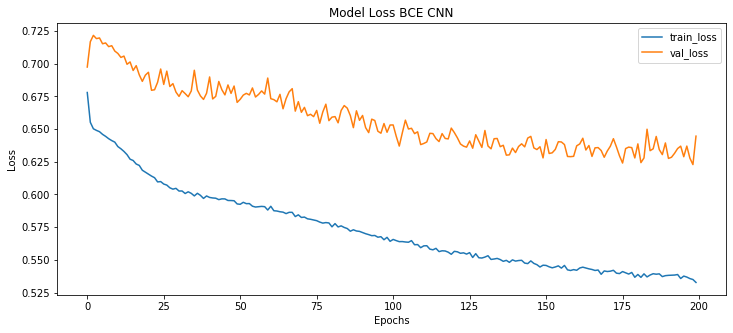

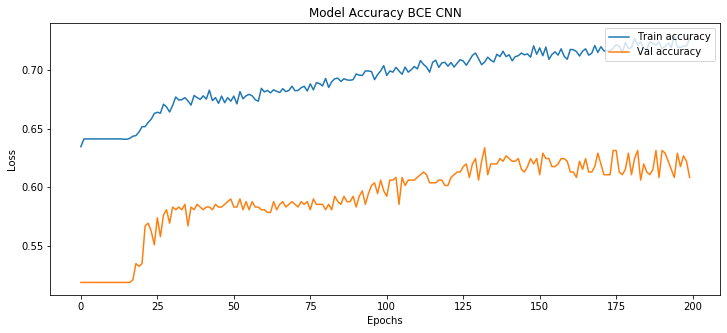

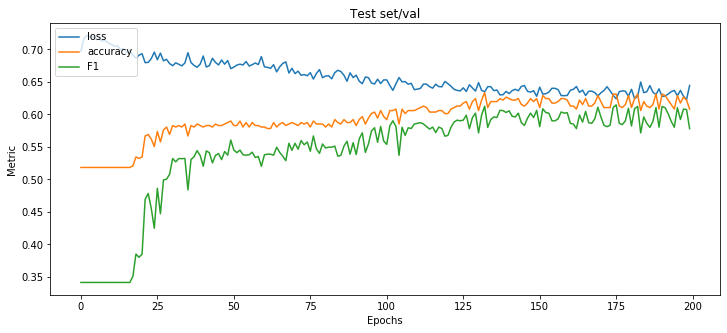

In [26]:
x_all=np.load("../obj4/LC_features/FourierICA_300T_32D.npy")
x_all = x_all[:,:16]

x_train = x_all[mask_train]
x_val = x_all[mask_test]

    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

foldICA = Sequential()
foldICA.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
foldICA.add(Dropout(0.25))
foldICA.add(Dense(1, activation='sigmoid'))

train_model(foldICA, x_train, y_train, e=200, BS=128, focal=False,save_f='./models/baseline_foldICA.hdf5')

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.748563    0.835605  0.789693     0.701059  0.663017   
Confirmed            0.610266    0.478390  0.536341     0.701059  0.663017   

                F1 micro  
False Positive  0.710636  
Confirmed       0.710636

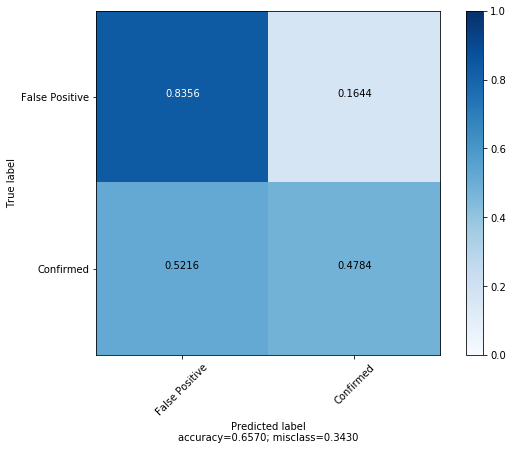

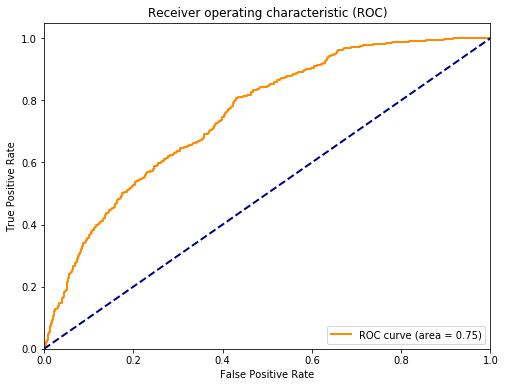

In [27]:
foldICA_loaded = keras.models.load_model("./models/baseline_foldICA.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=foldICA_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = foldICA_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

#### AE

Objetos de entrenamiento: (4339, 16) (4339,)
Objetos de validación: (1918, 16) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 2s 397us/step - loss: 0.6477 - acc: 0.6241 - val_loss: 0.6491 - val_acc: 0.5300
 - val_f1: 0.393257 
Epoch 2/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.5818 - acc: 0.6738 - val_loss: 0.6334 - val_acc: 0.5507
 - val_f1: 0.421654 
Epoch 3/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.5459 - acc: 0.7058 - val_loss: 0.5760 - val_acc: 0.6705
 - val_f1: 0.660913 
Epoch 4/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.5176 - acc: 0.7311 - val_loss: 0.5647 - val_acc: 0.6797
 - val_f1: 0.668165 
Epoch 5/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.5016 - acc: 0.7431 - val_loss: 0.5541 - val_acc: 0.7005
 - val_f1: 0.690985 
Epoch 6/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.

3905/3905 [==============================] - 0s 46us/step - loss: 0.4431 - acc: 0.7754 - val_loss: 0.5185 - val_acc: 0.7235
 - val_f1: 0.716117 
Epoch 53/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.4459 - acc: 0.7698 - val_loss: 0.5044 - val_acc: 0.7120
 - val_f1: 0.708263 
Epoch 54/200
3905/3905 [==============================] - 0s 45us/step - loss: 0.4476 - acc: 0.7711 - val_loss: 0.5034 - val_acc: 0.7166
 - val_f1: 0.713227 
Epoch 55/200
3905/3905 [==============================] - 0s 45us/step - loss: 0.4467 - acc: 0.7698 - val_loss: 0.4999 - val_acc: 0.7189
 - val_f1: 0.716722 
Epoch 56/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.4445 - acc: 0.7698 - val_loss: 0.5037 - val_acc: 0.7097
 - val_f1: 0.706082 
Epoch 57/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.4456 - acc: 0.7731 - val_loss: 0.5227 - val_acc: 0.7258
 - val_f1: 0.717823 
Epoch 58/200
3905/3905 [==============================] - 0s 46us

3905/3905 [==============================] - 0s 45us/step - loss: 0.4337 - acc: 0.7854 - val_loss: 0.4848 - val_acc: 0.7212
 - val_f1: 0.715949 
Epoch 105/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.4347 - acc: 0.7723 - val_loss: 0.4916 - val_acc: 0.7304
 - val_f1: 0.722566 
Epoch 106/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.4347 - acc: 0.7785 - val_loss: 0.4880 - val_acc: 0.7350
 - val_f1: 0.728152 
Epoch 107/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.4318 - acc: 0.7818 - val_loss: 0.4974 - val_acc: 0.7373
 - val_f1: 0.726592 
Epoch 108/200
3905/3905 [==============================] - 0s 45us/step - loss: 0.4318 - acc: 0.7851 - val_loss: 0.5009 - val_acc: 0.7442
 - val_f1: 0.734038 
Epoch 109/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.4326 - acc: 0.7839 - val_loss: 0.4861 - val_acc: 0.7327
 - val_f1: 0.725992 
Epoch 110/200
3905/3905 [==============================] - 0

 - val_f1: 0.742846 
Epoch 156/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.4280 - acc: 0.7908 - val_loss: 0.4852 - val_acc: 0.7512
 - val_f1: 0.744109 
Epoch 157/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.4263 - acc: 0.7867 - val_loss: 0.4867 - val_acc: 0.7512
 - val_f1: 0.741940 
Epoch 158/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.4220 - acc: 0.7933 - val_loss: 0.4887 - val_acc: 0.7442
 - val_f1: 0.734038 
Epoch 159/200
3905/3905 [==============================] - 0s 45us/step - loss: 0.4240 - acc: 0.7918 - val_loss: 0.4897 - val_acc: 0.7604
 - val_f1: 0.749601 
Epoch 160/200
3905/3905 [==============================] - 0s 45us/step - loss: 0.4239 - acc: 0.7918 - val_loss: 0.4757 - val_acc: 0.7419
 - val_f1: 0.735826 
Epoch 161/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.4281 - acc: 0.7882 - val_loss: 0.4911 - val_acc: 0.7627
 - val_f1: 0.751251 
Epoch 162/200
3905/3905 [

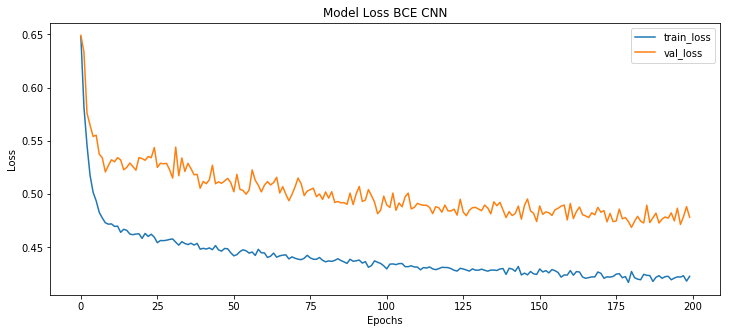

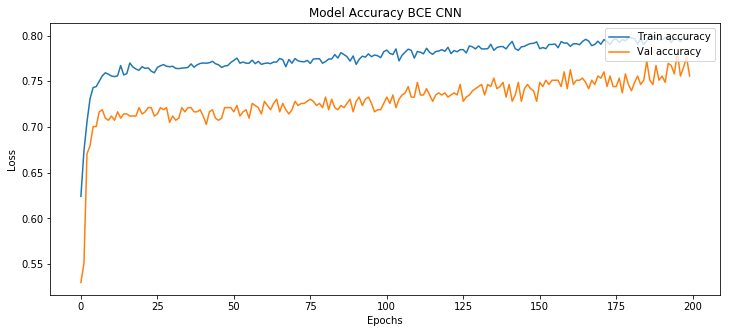

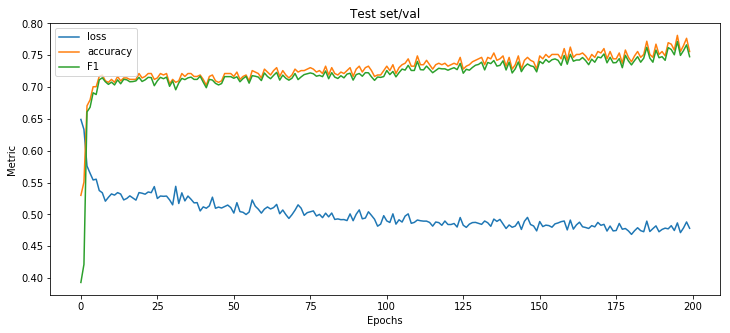

In [8]:
x_all=np.load("../obj4/LC_features/AE_300T_16D_simp.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]

print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

AE = Sequential()
AE.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
AE.add(Dropout(0.5))
AE.add(Dense(1, activation='sigmoid'))

train_model(AE, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_AE.hdf5')

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.784099  0.800834  0.844209      0.80215       0.858921   
Confirmed       0.784099  0.800834  0.723988      0.80215       0.702665   

                Recall raw  
False Positive    0.829992  
Confirmed         0.746647

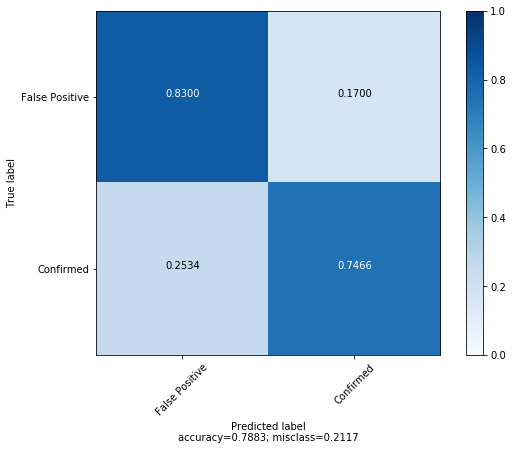

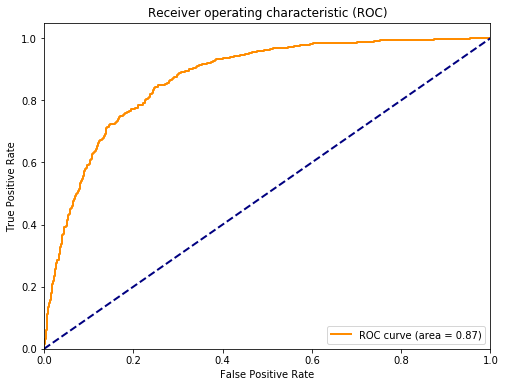

In [9]:
AE_loaded = keras.models.load_model("./models/baseline_AE.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=AE_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = AE_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob) ##16

#### VAE 

Objetos de entrenamiento: (4339, 16) (4339,)
Objetos de validación: (1918, 16) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 217us/step - loss: 0.6023 - acc: 0.6335 - val_loss: 0.6237 - val_acc: 0.5092
 - val_f1: 0.341558 
Epoch 2/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.5350 - acc: 0.6563 - val_loss: 0.5937 - val_acc: 0.6014
 - val_f1: 0.523987 
Epoch 3/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.5109 - acc: 0.7211 - val_loss: 0.5630 - val_acc: 0.6959
 - val_f1: 0.672453 
Epoch 4/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.4928 - acc: 0.7508 - val_loss: 0.5386 - val_acc: 0.7235
 - val_f1: 0.712741 
Epoch 5/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.4828 - acc: 0.7721 - val_loss: 0.5220 - val_acc: 0.7535
 - val_f1: 0.746676 
Epoch 6/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.

3905/3905 [==============================] - 0s 48us/step - loss: 0.3830 - acc: 0.8256 - val_loss: 0.4563 - val_acc: 0.7857
 - val_f1: 0.783385 
Epoch 53/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.3867 - acc: 0.8279 - val_loss: 0.4554 - val_acc: 0.7811
 - val_f1: 0.778936 
Epoch 54/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3825 - acc: 0.8302 - val_loss: 0.4561 - val_acc: 0.7811
 - val_f1: 0.778508 
Epoch 55/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3885 - acc: 0.8246 - val_loss: 0.4527 - val_acc: 0.7834
 - val_f1: 0.781555 
Epoch 56/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.3819 - acc: 0.8294 - val_loss: 0.4542 - val_acc: 0.7857
 - val_f1: 0.783590 
Epoch 57/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3862 - acc: 0.8256 - val_loss: 0.4525 - val_acc: 0.7834
 - val_f1: 0.781161 
Epoch 58/200
3905/3905 [==============================] - 0s 46us

3905/3905 [==============================] - 0s 55us/step - loss: 0.3743 - acc: 0.8343 - val_loss: 0.4506 - val_acc: 0.8018
 - val_f1: 0.800620 
Epoch 105/200
3905/3905 [==============================] - 0s 59us/step - loss: 0.3753 - acc: 0.8279 - val_loss: 0.4529 - val_acc: 0.7949
 - val_f1: 0.793429 
Epoch 106/200
3905/3905 [==============================] - 0s 59us/step - loss: 0.3681 - acc: 0.8366 - val_loss: 0.4514 - val_acc: 0.7926
 - val_f1: 0.791190 
Epoch 107/200
3905/3905 [==============================] - 0s 70us/step - loss: 0.3760 - acc: 0.8387 - val_loss: 0.4512 - val_acc: 0.7972
 - val_f1: 0.795830 
Epoch 108/200
3905/3905 [==============================] - 0s 65us/step - loss: 0.3712 - acc: 0.8394 - val_loss: 0.4519 - val_acc: 0.7949
 - val_f1: 0.793429 
Epoch 109/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3768 - acc: 0.8348 - val_loss: 0.4492 - val_acc: 0.7926
 - val_f1: 0.791190 
Epoch 110/200
3905/3905 [==============================] - 0

 - val_f1: 0.805256 
Epoch 156/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.3698 - acc: 0.8397 - val_loss: 0.4475 - val_acc: 0.8065
 - val_f1: 0.805256 
Epoch 157/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3672 - acc: 0.8384 - val_loss: 0.4475 - val_acc: 0.8088
 - val_f1: 0.807644 
Epoch 158/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3594 - acc: 0.8438 - val_loss: 0.4480 - val_acc: 0.8041
 - val_f1: 0.802865 
Epoch 159/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3659 - acc: 0.8369 - val_loss: 0.4500 - val_acc: 0.8065
 - val_f1: 0.805256 
Epoch 160/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3637 - acc: 0.8446 - val_loss: 0.4474 - val_acc: 0.8088
 - val_f1: 0.807644 
Epoch 161/200
3905/3905 [==============================] - 0s 47us/step - loss: 0.3619 - acc: 0.8405 - val_loss: 0.4460 - val_acc: 0.8041
 - val_f1: 0.803009 
Epoch 162/200
3905/3905 [

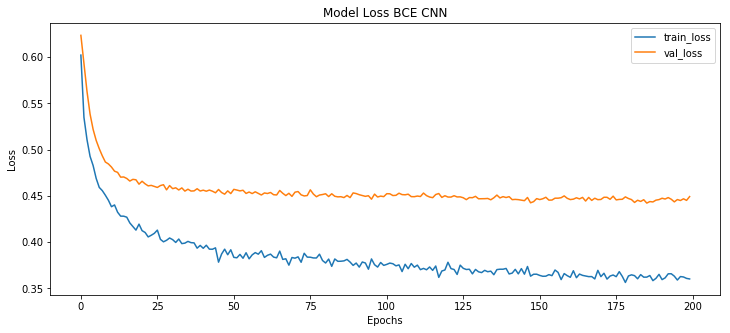

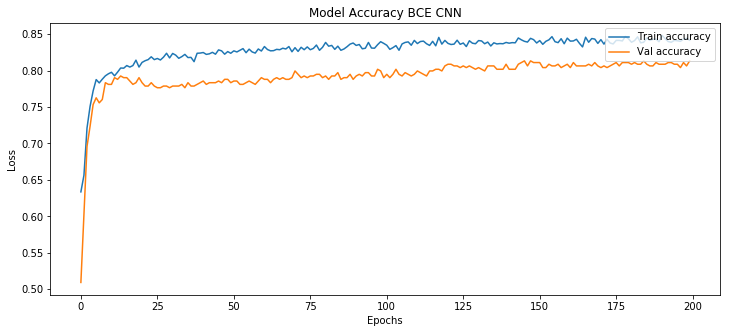

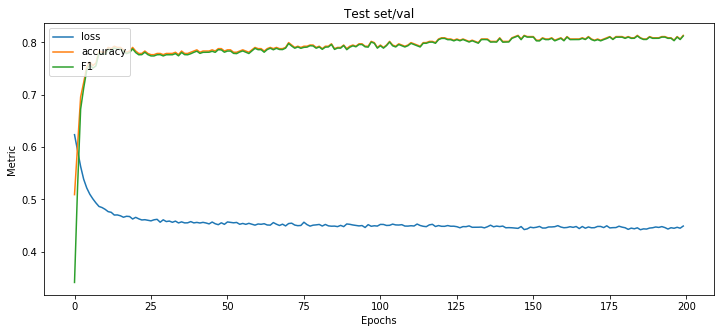

In [14]:
x_all=np.load("../obj4/LC_features/VAE_300T_16D.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

VAE = Sequential()
VAE.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
VAE.add(Dropout(0.5))
VAE.add(Dense(1, activation='sigmoid'))

train_model(VAE, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_VAE.hdf5')

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.798446  0.817518  0.860447     0.817066       0.855670   
Confirmed       0.798446  0.817518  0.736446     0.817066       0.744292   

                Recall raw  
False Positive    0.865277  
Confirmed         0.728763

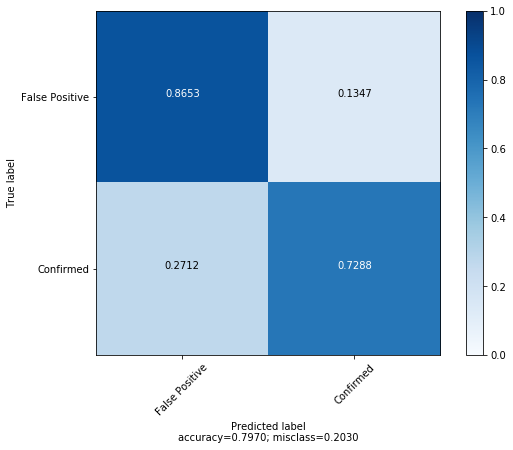

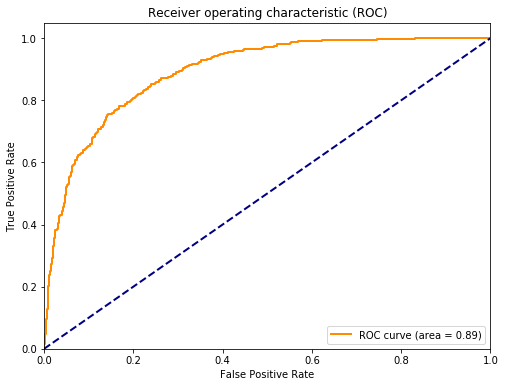

In [13]:
VAE_loaded = keras.models.load_model("./models/baseline_VAE.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=VAE_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = VAE_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive   0.80357  0.819082  0.858771     0.820147       0.871901   
Confirmed        0.80357  0.819082  0.748368     0.820147       0.728814   

                Recall raw  
False Positive    0.846030  
Confirmed         0.769001

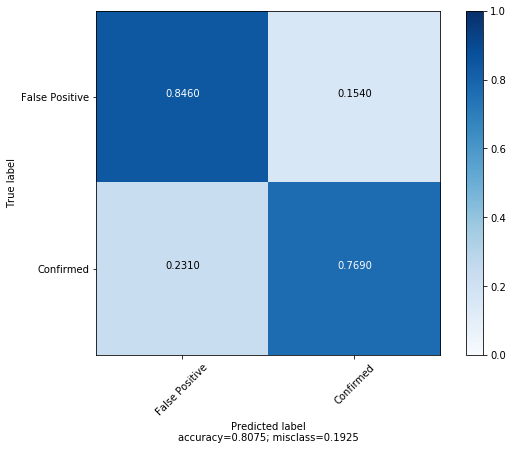

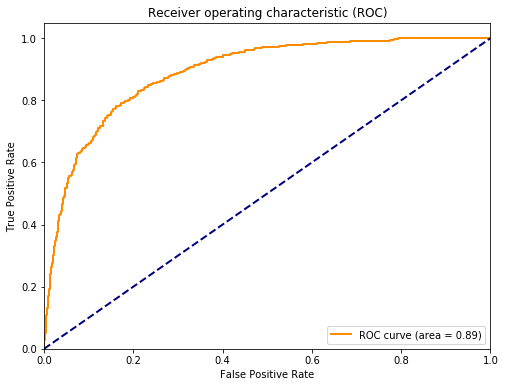

In [15]:
VAE_loaded = keras.models.load_model("./models/baseline_VAE.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=VAE_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

predichos_prob = VAE_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob) ##16

VAE sample no funciona bien..

#### VAE + escala

Objetos de entrenamiento: (4339, 16) (4339,)
Objetos de validación: (1918, 16) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 274us/step - loss: 0.5709 - acc: 0.7127 - val_loss: 0.5236 - val_acc: 0.7488
 - val_f1: 0.738333 
Epoch 2/200
3905/3905 [==============================] - 0s 54us/step - loss: 0.4558 - acc: 0.8046 - val_loss: 0.4605 - val_acc: 0.7903
 - val_f1: 0.785511 
Epoch 3/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.4198 - acc: 0.8136 - val_loss: 0.4367 - val_acc: 0.8111
 - val_f1: 0.808089 
Epoch 4/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.4033 - acc: 0.8210 - val_loss: 0.4261 - val_acc: 0.8180
 - val_f1: 0.815622 
Epoch 5/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3935 - acc: 0.8220 - val_loss: 0.4206 - val_acc: 0.8157
 - val_f1: 0.813386 
Epoch 6/200
3905/3905 [==============================] - 0s 52us/step - loss: 0.

3905/3905 [==============================] - 0s 50us/step - loss: 0.3365 - acc: 0.8428 - val_loss: 0.3724 - val_acc: 0.8295
 - val_f1: 0.828176 
Epoch 53/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3310 - acc: 0.8545 - val_loss: 0.3715 - val_acc: 0.8272
 - val_f1: 0.825782 
Epoch 54/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3352 - acc: 0.8461 - val_loss: 0.3681 - val_acc: 0.8272
 - val_f1: 0.825782 
Epoch 55/200
3905/3905 [==============================] - 0s 62us/step - loss: 0.3312 - acc: 0.8466 - val_loss: 0.3735 - val_acc: 0.8295
 - val_f1: 0.828032 
Epoch 56/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3372 - acc: 0.8435 - val_loss: 0.3658 - val_acc: 0.8318
 - val_f1: 0.830566 
Epoch 57/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3304 - acc: 0.8487 - val_loss: 0.3753 - val_acc: 0.8272
 - val_f1: 0.825476 
Epoch 58/200
3905/3905 [==============================] - 0s 49us

3905/3905 [==============================] - 0s 53us/step - loss: 0.3223 - acc: 0.8535 - val_loss: 0.3712 - val_acc: 0.8134
 - val_f1: 0.811845 
Epoch 105/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3228 - acc: 0.8530 - val_loss: 0.3709 - val_acc: 0.8180
 - val_f1: 0.816333 
Epoch 106/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3250 - acc: 0.8592 - val_loss: 0.3701 - val_acc: 0.8134
 - val_f1: 0.811845 
Epoch 107/200
3905/3905 [==============================] - 0s 52us/step - loss: 0.3220 - acc: 0.8586 - val_loss: 0.3627 - val_acc: 0.8180
 - val_f1: 0.816781 
Epoch 108/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3174 - acc: 0.8566 - val_loss: 0.3719 - val_acc: 0.8134
 - val_f1: 0.811845 
Epoch 109/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3251 - acc: 0.8528 - val_loss: 0.3653 - val_acc: 0.8157
 - val_f1: 0.814391 
Epoch 110/200
3905/3905 [==============================] - 0

 - val_f1: 0.816333 
Epoch 156/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3164 - acc: 0.8525 - val_loss: 0.3692 - val_acc: 0.8180
 - val_f1: 0.816490 
Epoch 157/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3141 - acc: 0.8540 - val_loss: 0.3651 - val_acc: 0.8180
 - val_f1: 0.816490 
Epoch 158/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3094 - acc: 0.8638 - val_loss: 0.3644 - val_acc: 0.8203
 - val_f1: 0.818888 
Epoch 159/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3137 - acc: 0.8617 - val_loss: 0.3699 - val_acc: 0.8157
 - val_f1: 0.813926 
Epoch 160/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3119 - acc: 0.8584 - val_loss: 0.3651 - val_acc: 0.8226
 - val_f1: 0.821282 
Epoch 161/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3005 - acc: 0.8650 - val_loss: 0.3670 - val_acc: 0.8203
 - val_f1: 0.818577 
Epoch 162/200
3905/3905 [

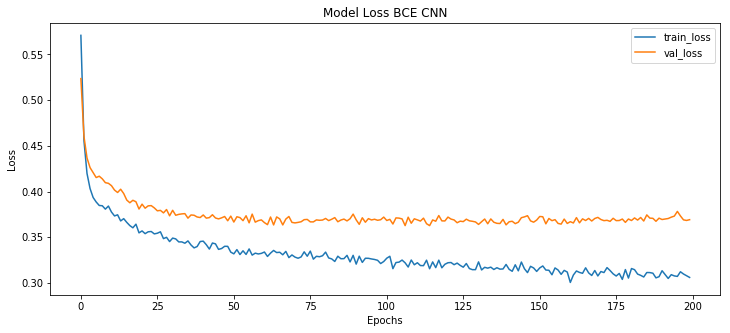

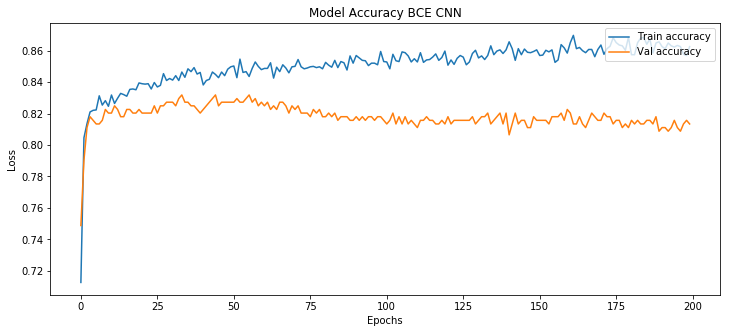

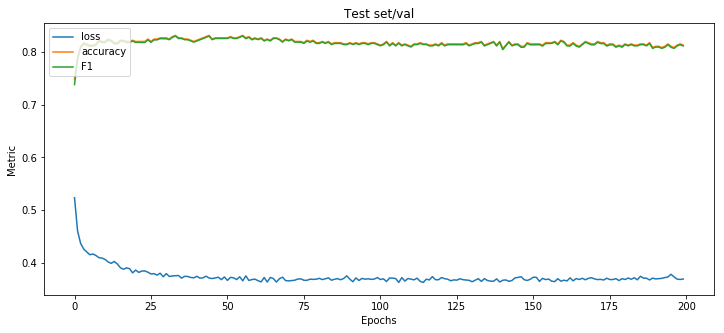

In [18]:
x_all=np.load("../obj4/LC_features/VAE_S_300T_16D.npy")
#x_all2=np.load("../obj4/LC_features/VAE_S_300T_32D_var.npy")
#x_all = np.concatenate([x_all,x_all2], axis=-1)

x_train = x_all[mask_train]
x_val = x_all[mask_test]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

VAEs = Sequential()
VAEs.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
VAEs.add(Dropout(0.5))
VAEs.add(Dense(1, activation='sigmoid'))

train_model(VAEs, x_train, y_train, e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_VAEs.hdf5')

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.821049  0.834202  0.869565     0.835619       0.890008   
Confirmed       0.821049  0.834202  0.772532     0.835619       0.742779   

                Recall raw  
False Positive    0.850040  
Confirmed         0.804769

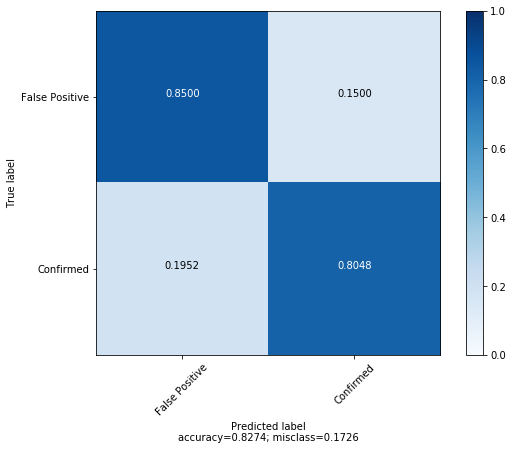

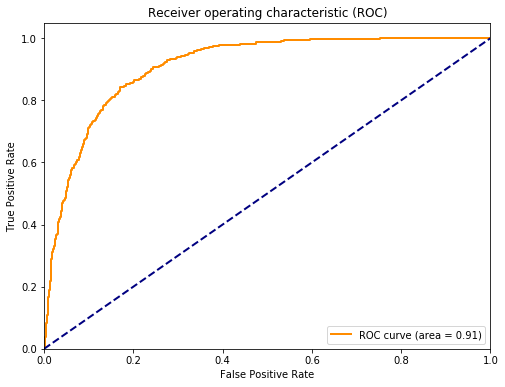

In [17]:
VAEs_loaded = keras.models.load_model("./models/baseline_VAEs.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=VAEs_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double

predichos_prob = VAEs_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob) #S

#### VAE + escala --> 16

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.826463  0.839416  0.873874     0.840701       0.892887   
Confirmed       0.826463  0.839416  0.779053     0.840701       0.751037   

                Recall raw  
False Positive    0.855654  
Confirmed         0.809240

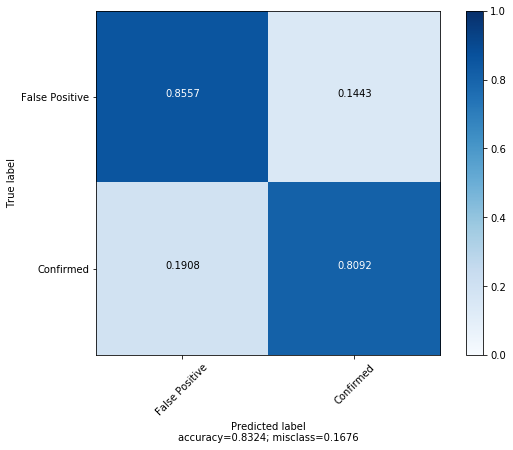

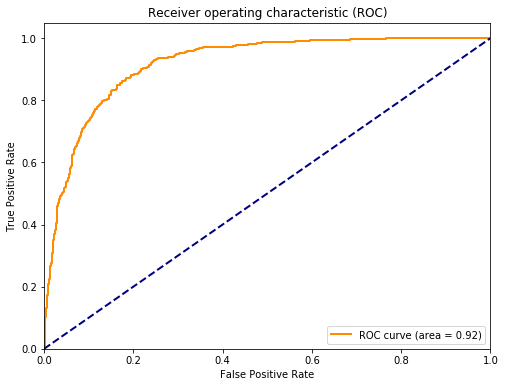

In [20]:
VAEs_loaded = keras.models.load_model("./models/baseline_VAEs.hdf5") #con 4 capas (64 y 128) con dropa en todo

predichos=VAEs_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double

predichos_prob = VAEs_loaded.predict(x_val)
plot_ROC(y_val, predichos_prob)

## Folded inputs

In [24]:
T = 2001 #300
x_all = np.load("../obj4/data/LC_global_%dT.npy"%T)[:,:,None]
#x_all2 = np.load("../obj4/data/LC_globalA_%dT.npy"%T)[:,:,None]

###x_all = x_all/x_all.std(axis=1, keepdims=True)
x_all = x_all/np.abs(x_all.min(axis=1, keepdims=True))
#x_all2 = x_all2/np.abs(x_all2.min(axis=1, keepdims=True))

x_train = x_all[mask_train]
#x_train2 = x_all2[mask_train]
#x_train = np.concatenate([x_train,x_train2]) #concat

x_val = x_all[mask_test]

if x_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (8774, 2001, 1) (8774,)
Objetos de validación: (1870, 2001, 1) (1870,)


### Shallue Inspired with global input only

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 300, 16)           96        
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 300, 16)           1296      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 148, 16)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 148, 32)           2592      
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 148, 32)           5152      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 72, 32)            0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 72, 64)            10304     
__________

3905/3905 [==============================] - 0s 109us/step - loss: 3.8305e-04 - acc: 1.0000 - val_loss: 1.5598 - val_acc: 0.8203
 - val_f1: 0.819525 
Epoch 91/200
3905/3905 [==============================] - 0s 111us/step - loss: 0.0024 - acc: 0.9990 - val_loss: 1.6937 - val_acc: 0.7857
 - val_f1: 0.782714 
Epoch 92/200
3905/3905 [==============================] - 0s 110us/step - loss: 0.0108 - acc: 0.9967 - val_loss: 1.2025 - val_acc: 0.8249
 - val_f1: 0.824751 
Epoch 93/200
3905/3905 [==============================] - 0s 116us/step - loss: 0.0292 - acc: 0.9880 - val_loss: 1.0281 - val_acc: 0.8157
 - val_f1: 0.814089 
Epoch 94/200
3905/3905 [==============================] - 0s 110us/step - loss: 0.0438 - acc: 0.9851 - val_loss: 1.2560 - val_acc: 0.7857
 - val_f1: 0.781680 
Epoch 95/200
3905/3905 [==============================] - 0s 114us/step - loss: 0.0265 - acc: 0.9910 - val_loss: 1.0413 - val_acc: 0.8433
 - val_f1: 0.843105 
Epoch 96/200
3905/3905 [==============================]

3905/3905 [==============================] - 0s 113us/step - loss: 4.4651e-05 - acc: 1.0000 - val_loss: 1.6402 - val_acc: 0.8180
 - val_f1: 0.816914 
Epoch 192/200
3905/3905 [==============================] - 0s 115us/step - loss: 2.3760e-05 - acc: 1.0000 - val_loss: 1.6410 - val_acc: 0.8203
 - val_f1: 0.819167 
Epoch 193/200
3905/3905 [==============================] - 0s 117us/step - loss: 2.5607e-05 - acc: 1.0000 - val_loss: 1.6553 - val_acc: 0.8226
 - val_f1: 0.821419 
Epoch 194/200
3905/3905 [==============================] - 0s 111us/step - loss: 2.8188e-05 - acc: 1.0000 - val_loss: 1.6501 - val_acc: 0.8203
 - val_f1: 0.819167 
Epoch 195/200
3905/3905 [==============================] - 0s 113us/step - loss: 2.4190e-05 - acc: 1.0000 - val_loss: 1.6523 - val_acc: 0.8180
 - val_f1: 0.816914 
Epoch 196/200
3905/3905 [==============================] - 0s 114us/step - loss: 1.8665e-05 - acc: 1.0000 - val_loss: 1.6540 - val_acc: 0.8180
 - val_f1: 0.816914 
Epoch 197/200
3905/3905 [=====

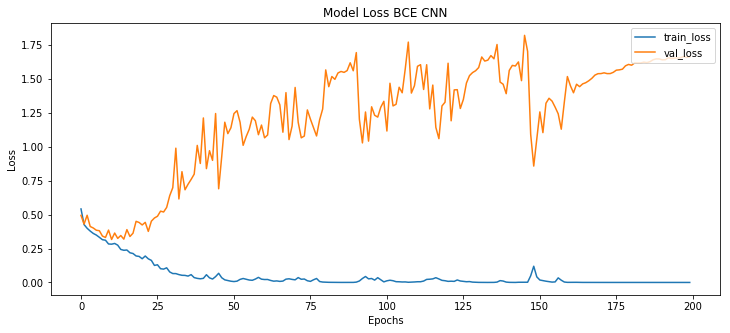

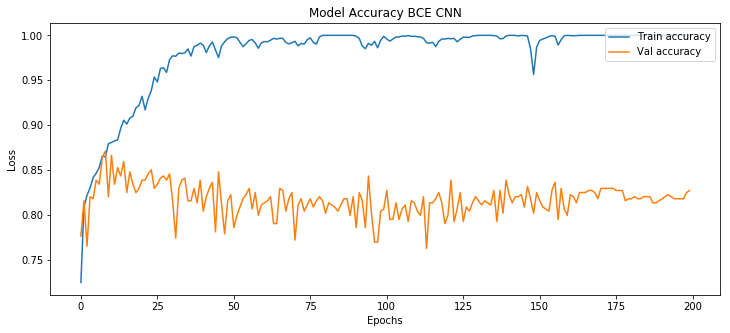

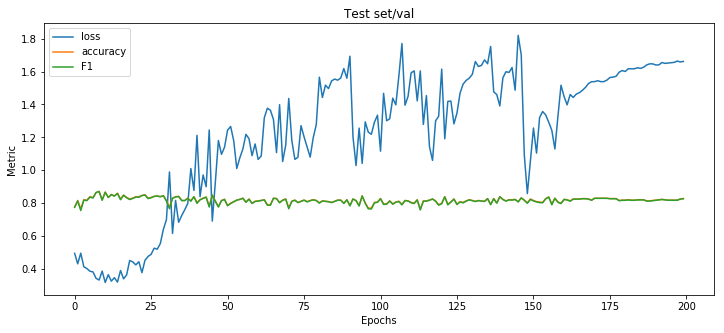

In [33]:
#parte convolucional y pre-procesamiento de shallue
CNN_shallue = Sequential()
CNN_shallue.add(Conv1D(16, 5, activation='relu', padding="same",input_shape=x_train.shape[1:]))
CNN_shallue.add(Conv1D(16, 5, activation='relu', padding="same"))
CNN_shallue.add(MaxPooling1D(pool_size=5, strides=2))

CNN_shallue.add(Conv1D(32, 5, activation='relu', padding="same"))
CNN_shallue.add(Conv1D(32, 5, activation='relu', padding="same"))
CNN_shallue.add(MaxPooling1D(pool_size=5, strides=2))

CNN_shallue.add(Conv1D(64, 5, activation='relu', padding="same"))
CNN_shallue.add(Conv1D(64, 5, activation='relu', padding="same"))
CNN_shallue.add(MaxPooling1D(pool_size=5, strides=2))
#until third block of Shallue

CNN_shallue.add(Flatten())

CNN_shallue.add(Dense(128, activation='relu'))
CNN_shallue.add(Dropout(0.5))
#a simple fully connected layer

CNN_shallue.add(Dense(1, activation='sigmoid'))
CNN_shallue.summary()

train_model(CNN_shallue, x_train, y_train, 
            e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_CNN_shall.hdf5')

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.853348  0.863921  0.892725     0.865173       0.915683   
Confirmed       0.853348  0.863921  0.813970     0.865173       0.780055   

                Recall raw  
False Positive    0.870890  
Confirmed         0.850969

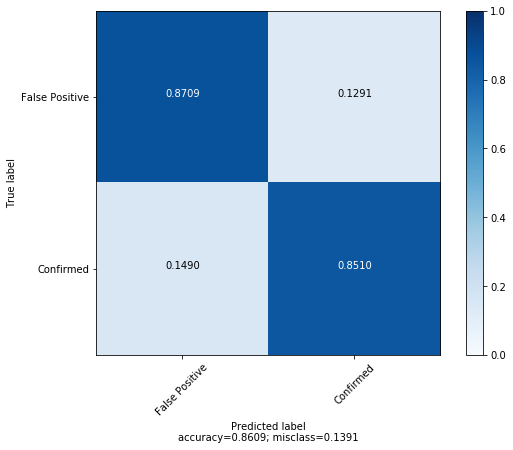

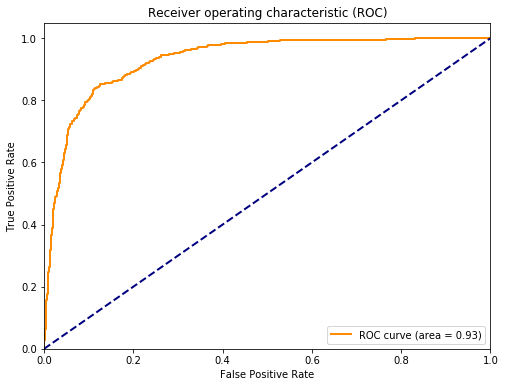

In [20]:
CNN_shallue_l = keras.models.load_model('./models/baseline_CNN_shall.hdf5') #con 4 capas (64 y 128) con dropa en todo

predichos=CNN_shallue_l.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double

predichos_prob = CNN_shallue_l.predict(x_val)
plot_ROC(y_val, predichos_prob)

### RNN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 300, 64)           6720      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_47 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 129       
Total params: 33,985
Trainable params: 33,985
Non-trainable params: 0
_________________________________________________________________
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 8s 2ms/step - loss: 0.6273 - acc: 

3905/3905 [==============================] - 3s 643us/step - loss: 0.3039 - acc: 0.8676 - val_loss: 0.4001 - val_acc: 0.8203
 - val_f1: 0.817859 
Epoch 47/200
3905/3905 [==============================] - 3s 651us/step - loss: 0.3081 - acc: 0.8661 - val_loss: 0.3868 - val_acc: 0.8249
 - val_f1: 0.822895 
Epoch 48/200
3905/3905 [==============================] - 3s 641us/step - loss: 0.3027 - acc: 0.8612 - val_loss: 0.4187 - val_acc: 0.8203
 - val_f1: 0.817859 
Epoch 49/200
3905/3905 [==============================] - 2s 637us/step - loss: 0.3080 - acc: 0.8643 - val_loss: 0.3882 - val_acc: 0.8180
 - val_f1: 0.815424 
Epoch 50/200
3905/3905 [==============================] - 3s 655us/step - loss: 0.3005 - acc: 0.8686 - val_loss: 0.4648 - val_acc: 0.7811
 - val_f1: 0.775430 
Epoch 51/200
3905/3905 [==============================] - 3s 642us/step - loss: 0.3012 - acc: 0.8648 - val_loss: 0.3842 - val_acc: 0.8318
 - val_f1: 0.829969 
Epoch 52/200
3905/3905 [==============================] - 2

 - val_f1: 0.847095 
Epoch 98/200
3905/3905 [==============================] - 3s 641us/step - loss: 0.2258 - acc: 0.9063 - val_loss: 0.4063 - val_acc: 0.8387
 - val_f1: 0.838215 
Epoch 99/200
3905/3905 [==============================] - 3s 644us/step - loss: 0.2314 - acc: 0.8953 - val_loss: 0.4109 - val_acc: 0.8295
 - val_f1: 0.828674 
Epoch 100/200
3905/3905 [==============================] - 3s 650us/step - loss: 0.2260 - acc: 0.9012 - val_loss: 0.5447 - val_acc: 0.8065
 - val_f1: 0.802419 
Epoch 101/200
3905/3905 [==============================] - 3s 649us/step - loss: 0.2396 - acc: 0.8937 - val_loss: 0.4221 - val_acc: 0.8341
 - val_f1: 0.833408 
Epoch 102/200
3905/3905 [==============================] - 2s 631us/step - loss: 0.2254 - acc: 0.8999 - val_loss: 0.4482 - val_acc: 0.8249
 - val_f1: 0.823928 
Epoch 103/200
3905/3905 [==============================] - 3s 655us/step - loss: 0.2230 - acc: 0.9099 - val_loss: 0.4050 - val_acc: 0.8410
 - val_f1: 0.840089 
Epoch 104/200
3905/39

3905/3905 [==============================] - 3s 641us/step - loss: 0.1230 - acc: 0.9526 - val_loss: 0.6242 - val_acc: 0.8180
 - val_f1: 0.817366 
Epoch 150/200
3905/3905 [==============================] - 3s 647us/step - loss: 0.1459 - acc: 0.9480 - val_loss: 0.7433 - val_acc: 0.8041
 - val_f1: 0.802019 
Epoch 151/200
3905/3905 [==============================] - 3s 657us/step - loss: 0.1247 - acc: 0.9560 - val_loss: 0.6015 - val_acc: 0.8272
 - val_f1: 0.826518 
Epoch 152/200
3905/3905 [==============================] - 3s 654us/step - loss: 0.1262 - acc: 0.9524 - val_loss: 0.7421 - val_acc: 0.8065
 - val_f1: 0.804622 
Epoch 153/200
3905/3905 [==============================] - 3s 648us/step - loss: 0.1271 - acc: 0.9531 - val_loss: 0.6091 - val_acc: 0.8272
 - val_f1: 0.826414 
Epoch 154/200
3905/3905 [==============================] - 3s 647us/step - loss: 0.1120 - acc: 0.9588 - val_loss: 0.6996 - val_acc: 0.8364
 - val_f1: 0.835454 
Epoch 155/200
3905/3905 [=============================

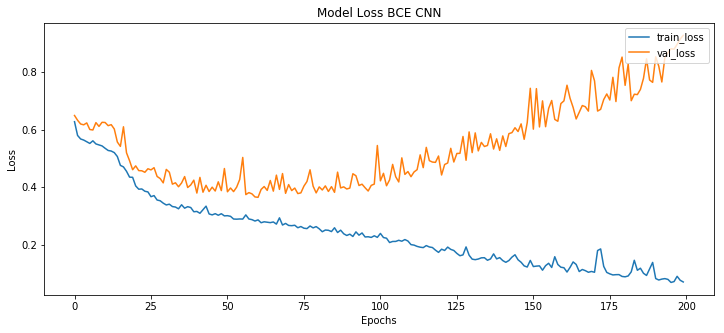

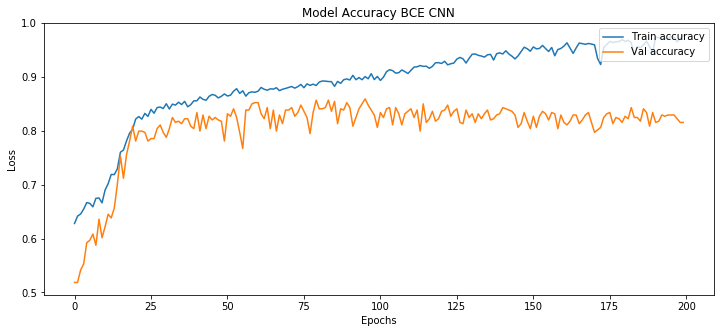

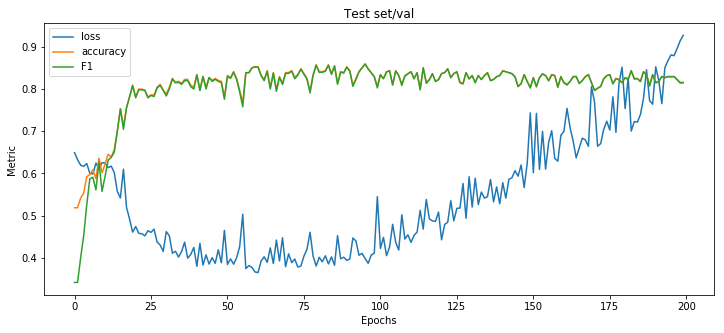

In [46]:
RNN_aux = Sequential()
RNN_aux.add(Bidirectional(CuDNNGRU(64, return_sequences=True),input_shape=x_train.shape[1:]))
RNN_aux.add(Bidirectional(CuDNNGRU(64, return_sequences=False)))

RNN_aux.add(Dense(128, activation='relu'))
RNN_aux.add(Dropout(0.5))

RNN_aux.add(Dense(1, activation='sigmoid'))
RNN_aux.summary()

#original, BS = 64 y 50 epochs
train_model(RNN_aux, x_train, y_train, 
            e=200, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_RNN.h5')

F1 macro  F1 micro    F1 raw  F1 weighted  Precision raw  \
False Positive  0.838729  0.852972  0.886656     0.853122       0.888799   
Confirmed       0.838729  0.852972  0.790801     0.853122       0.787297   

                Recall raw  
False Positive    0.884523  
Confirmed         0.794337

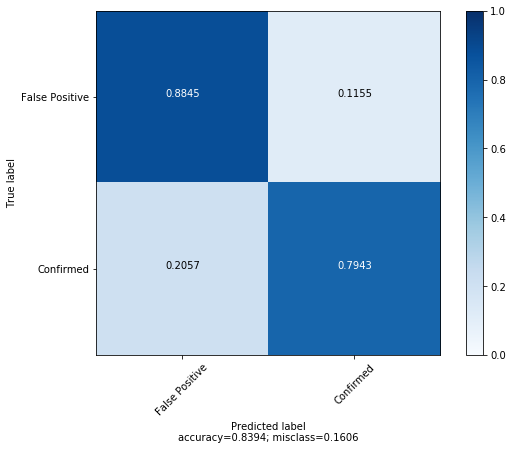

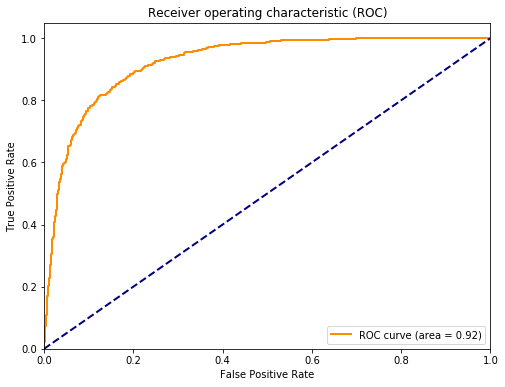

In [41]:
RNN_aux = keras.models.load_model('./models/baseline_RNN.h5') #con 4 capas (64 y 128) con dropa en todo
predichos=RNN_aux.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double

predichos_prob = RNN_aux.predict(x_val)
plot_ROC(y_val, predichos_prob)

|Técnicas     |F1-macro| 
|---          |---     |
|Metadata     | 87.13  |
|--- |---|
|Feets|???|
|Fou+PCA(32)  | 69.29  |
|Fou+PCA(MTF) | 68.68  |
| CNN-deep (LC) *   | ??  |
| **CNN (MTF)**   | 76.93  |
| **CNN-deep (MTF)**   | gabo  |

(*) C. Aguirre (2018) a estrellas variables

|Técnicas         |F1-macro| 
|---              |---     |
|--- |---|
|Fold-Glo(300)    | 77.57  |
|--- |---|
| AE (32)         | 79.10  |
| **VAE (32)**    | 79.84  |
|**VAE-scale(32)**| 82.10  | 
| AE (16)         | 75.18  |
| **VAE (16)**    | 80.36  |
|**VAE-scale(16)**| 82.65  | 
|Shallue CNN(Fold)| 85.33  |
|Encoder-class(*)    | 83.87  | 

(*) máxima capacidad supervisada de arquitecturas AE

### CNN state-of-the-art
* T global = 2001
* T local = 201
* very deep model 

> our selected without local view

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 2001, 1)           0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 2001, 16)          96        
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 2001, 16)          1296      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 999, 16)           0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 999, 32)           2592      
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 999, 32)           5152      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 498, 32)           0   

 - val_f1: 0.889775 
Epoch 39/50
7896/7896 [==============================] - 2s 269us/step - loss: 0.0582 - acc: 0.9806 - val_loss: 0.5014 - val_acc: 0.8872
 - val_f1: 0.884513 
Epoch 40/50
7896/7896 [==============================] - 2s 269us/step - loss: 0.0597 - acc: 0.9780 - val_loss: 0.5678 - val_acc: 0.8998
 - val_f1: 0.898114 
Epoch 41/50
7896/7896 [==============================] - 2s 271us/step - loss: 0.0556 - acc: 0.9796 - val_loss: 0.6158 - val_acc: 0.8964
 - val_f1: 0.894482 
Epoch 42/50
7896/7896 [==============================] - 2s 273us/step - loss: 0.0480 - acc: 0.9843 - val_loss: 0.6309 - val_acc: 0.9009
 - val_f1: 0.898993 
Epoch 43/50
7896/7896 [==============================] - 2s 272us/step - loss: 0.0442 - acc: 0.9848 - val_loss: 0.5652 - val_acc: 0.8952
 - val_f1: 0.892793 
Epoch 44/50
7896/7896 [==============================] - 2s 271us/step - loss: 0.0446 - acc: 0.9837 - val_loss: 0.8327 - val_acc: 0.8827
 - val_f1: 0.879305 
Epoch 45/50
7896/7896 [========

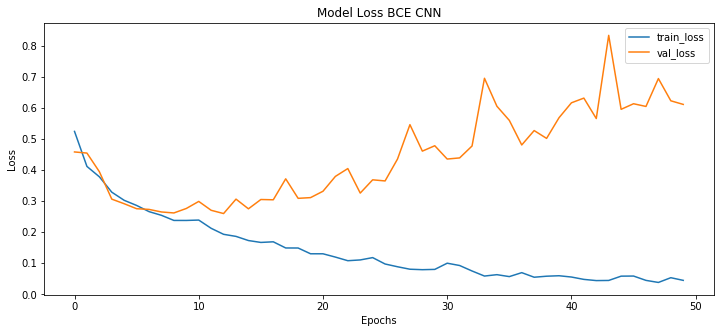

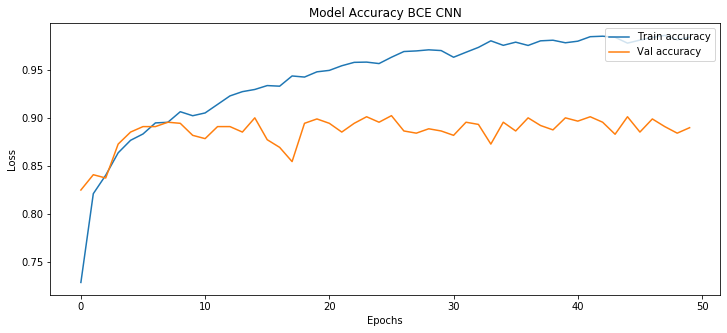

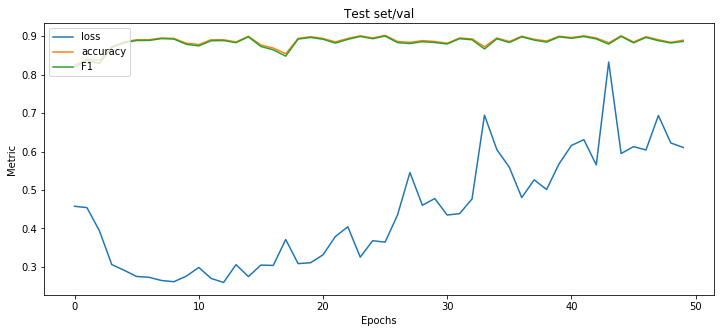

In [25]:
it_global = Input(shape=x_train.shape[1:])
cnn_glob = Conv1D(16, 5, activation='relu', padding="same")(it_global)
cnn_glob = Conv1D(16, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Conv1D(32, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = Conv1D(32, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Conv1D(64, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = Conv1D(64, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Flatten()(cnn_glob)
#until third block of shallue

fc = Dense(128, activation='relu')(cnn_glob)
fc = Dropout(0.5)(fc)
out = Dense(1, activation='sigmoid')(fc)
#simple fully connected model

CNN_shallue = Model(inputs=it_global, outputs=out)
CNN_shallue.summary()

train_model(CNN_shallue, x_train, y_train[:,None], 
            e=50, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_CNN_global.h5')

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.919469    0.876054  0.897237     0.873691  0.865051   
Confirmed            0.801351    0.866959  0.832865     0.873691  0.865051   

                F1 micro  Accuracy  
False Positive  0.872727  0.872727  
Confirmed       0.872727  0.872727

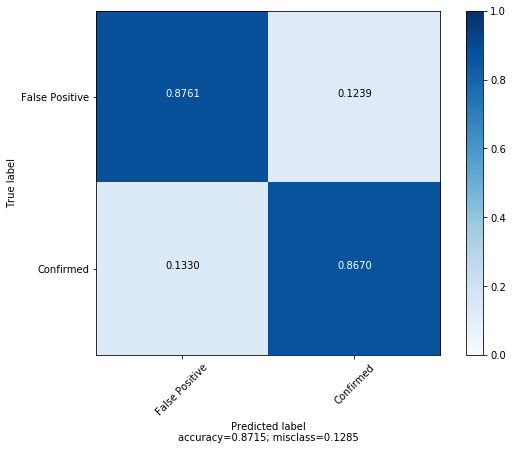

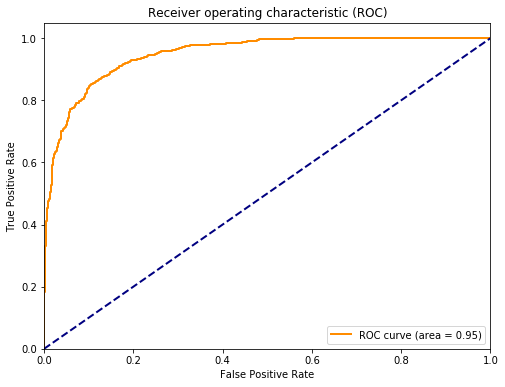

In [23]:
CNN_shallue_l = keras.models.load_model('./models/baseline_CNN_global.h5')

predichos=model_predict_class(CNN_shallue_l, x_val) 
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample')

predichos_prob = CNN_shallue_l.predict(x_val)
plot_ROC(y_val, predichos_prob) 

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.941075    0.915683  0.928205     0.910573  0.904103   
Confirmed            0.860335    0.900585  0.880000     0.910573  0.904103   

                F1 micro  Accuracy  
False Positive   0.91016   0.91016  
Confirmed        0.91016   0.91016

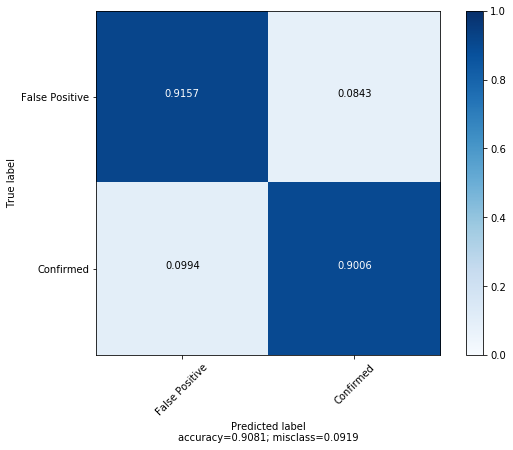

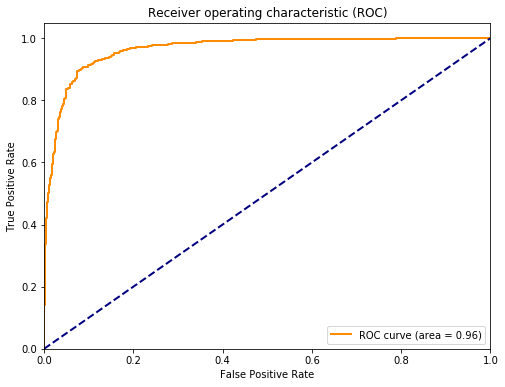

In [26]:
CNN_shallue_l = keras.models.load_model('./models/baseline_CNN_global.h5')

predichos=model_predict_class(CNN_shallue_l, x_val) 
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample')

predichos_prob = CNN_shallue_l.predict(x_val)
plot_ROC(y_val, predichos_prob)  #mirroring

In [27]:
## load local
T_local = 201
x_all_l = np.load("../obj4/data/LC_local_%dT.npy"%T_local)[:,:,None]
#x_all2_l = np.load("../obj4/data/LC_localA_%dT.npy"%T_local)[:,:,None]
x_all_l = x_all_l/np.abs(x_all_l.min(axis=1, keepdims=True))
#x_all2_l = x_all2_l/np.abs(x_all2_l.min(axis=1, keepdims=True))

x_train_local = x_all_l[mask_train]
#x_train2_local = x_all2_l[mask_train]
#x_train_local = np.concatenate([x_train_local,x_train2_local]) #concat

x_val_local = x_all_l[mask_test]
print ("Objetos de entrenamiento:",x_train_local.shape)

Objetos de entrenamiento: (8774, 201, 1)


* local ayuda a subir 2-3 puntos approx
* curas invertidas ayuda a subir 1 punto approx

> Shallue 2018 - Astronet

#parte convolucional y pre-procesamiento de shallue (Astronet-S)
it_global = Input(shape=x_train.shape[1:])
cnn_glob = Conv1D(16, 5, activation='relu', padding="same")(it_global)
cnn_glob = Conv1D(16, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Conv1D(32, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = Conv1D(32, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Conv1D(64, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = Conv1D(64, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Conv1D(128, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = Conv1D(128, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Conv1D(256, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = Conv1D(256, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Flatten()(cnn_glob)

##local part - revisar shallue
it_local = Input(shape=x_train_local.shape[1:])
cnn_loc = Conv1D(16, 5, activation='relu', padding="same")(it_local)
cnn_loc = Conv1D(16, 5, activation='relu', padding="same")(cnn_loc)
cnn_loc = MaxPooling1D(pool_size=7, strides=2)(cnn_loc)
cnn_loc = Conv1D(32, 5, activation='relu', padding="same")(cnn_loc) 
cnn_loc = Conv1D(32, 5, activation='relu', padding="same")(cnn_loc)
cnn_loc = MaxPooling1D(pool_size=7, strides=2)(cnn_loc)
cnn_loc = Flatten()(cnn_loc)

concat_cnn = keras.layers.Concatenate()([cnn_glob, cnn_loc])
#concat_cnn = cnn_glob

fc = Dense(512, activation='relu')(concat_cnn)
fc = Dense(512, activation='relu')(fc)
fc = Dense(512, activation='relu')(fc)
fc = Dense(512, activation='relu')(fc)
out = Dense(1, activation='sigmoid')(fc)

it_total = [it_global, it_local]
CNN_shallue = Model(inputs=it_total, outputs=out)
CNN_shallue.summary()

train_model(CNN_shallue, [x_train, x_train_local], y_train[:,None], 
            e=50, BS=64, focal=False,alpha=0.6,save_f='./models/baseline_CNN_shall_full.hdf5')

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 2001, 1)      0                                            
__________________________________________________________________________________________________
conv1d_109 (Conv1D)             (None, 2001, 16)     96          input_23[0][0]                   
__________________________________________________________________________________________________
conv1d_110 (Conv1D)             (None, 2001, 16)     1296        conv1d_109[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_53 (MaxPooling1D) (None, 999, 16)      0           conv1d_110[0][0]                 
___________________________________________________________________________________________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.944154    0.912310  0.927959     0.910666   0.90432   
Confirmed            0.856354    0.906433  0.880682     0.910666   0.90432   

                F1 micro  Accuracy  
False Positive   0.91016   0.91016  
Confirmed        0.91016   0.91016

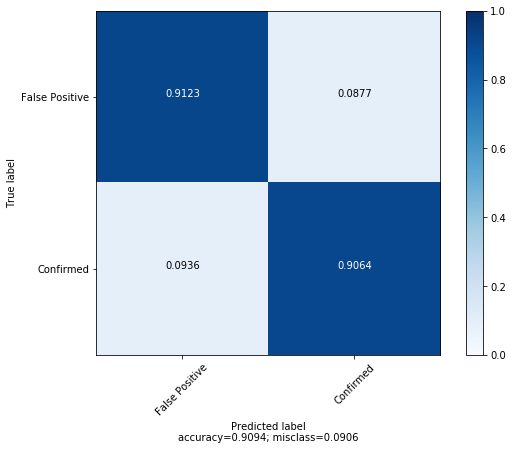

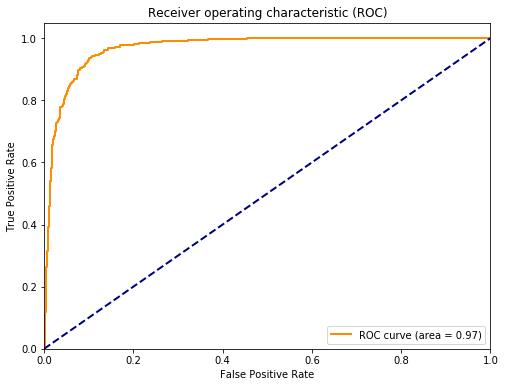

In [31]:
CNN_shallue_l = keras.models.load_model('./models/baseline_CNN_shall_full.h5') 
CNN_shallue_l.summary()

predichos=model_predict_class(CNN_shallue_l, [x_val, x_val_local])
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double

predichos_prob = CNN_shallue_l.predict([x_val,x_val_local])
plot_ROC(y_val, predichos_prob) #mirroring

> Andswel 2020 - Astronet-XS

it_global = Input(shape=x_train.shape[1:])
cnn_glob = Conv1D(16, 5, activation='relu', padding="same")(it_global)
cnn_glob = MaxPooling1D(pool_size=2, strides=2)(cnn_glob)
cnn_glob = Conv1D(16, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=2, strides=2)(cnn_glob)
cnn_glob = Conv1D(32, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = GlobalMaxPooling1D()(cnn_glob)
                             
##local part
it_local = Input(shape=x_train_local.shape[1:])
cnn_loc = Conv1D(16, 5, activation='relu', padding="same")(it_local)
cnn_loc = MaxPooling1D(pool_size=2, strides=2)(cnn_loc)
cnn_loc = Conv1D(16, 5, activation='relu', padding="same")(cnn_loc)
cnn_loc = GlobalMaxPooling1D()(cnn_loc)

concat_cnn = keras.layers.Concatenate()([cnn_glob, cnn_loc])
#concat_cnn = cnn_glob

fc = Dense(512, activation='relu')(concat_cnn)
out = Dense(1, activation='sigmoid')(fc)

it_total = [it_global, it_local]
CNN_astronetXS = Model(inputs=it_total, outputs=out)
CNN_astronetXS.summary()

train_model(CNN_astronetXS, [x_train, x_train_local], y_train, 
            e=50, BS=64, focal=False,alpha=0.6,save_f='./models/baseline_CNN_astronetXS.h5')

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 2001, 1)      0                                            
__________________________________________________________________________________________________
conv1d_91 (Conv1D)              (None, 2001, 16)     96          input_17[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_46 (MaxPooling1D) (None, 1000, 16)     0           conv1d_91[0][0]                  
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 201, 1)       0                                            
___________________________________________________________________________________________

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.918033    0.897133  0.907463     0.884412  0.875954   
Confirmed            0.828411    0.861111  0.844444     0.884412  0.875954   

                F1 micro  Accuracy  
False Positive  0.883957  0.883957  
Confirmed       0.883957  0.883957

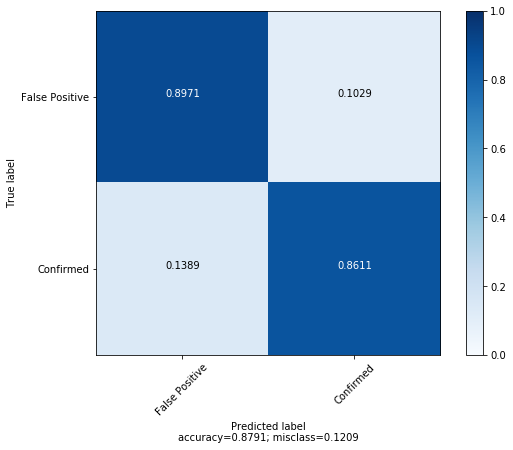

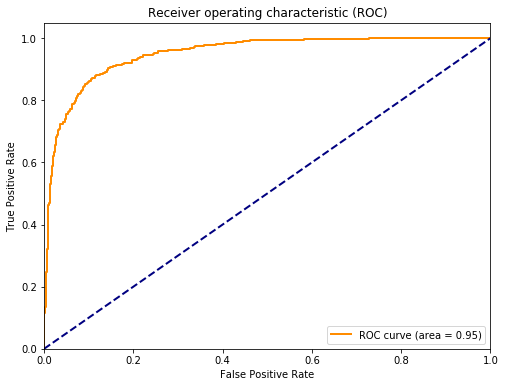

In [33]:
CNN_astronetXS_l = keras.models.load_model('./models/baseline_CNN_astronetXS.h5') 
CNN_astronetXS_l.summary()

predichos = model_predict_class(CNN_astronetXS_l, [x_val, x_val_local]) #CNN_astronetXS_l.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double

predichos_prob = CNN_astronetXS_l.predict([x_val, x_val_local])
plot_ROC(y_val, predichos_prob) #mirroring

> our selected with local view

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 2001, 1)      0                                            
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 2001, 16)     96          input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, 2001, 16)     1296        conv1d_67[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_34 (MaxPooling1D) (None, 999, 16)      0           conv1d_68[0][0]                  
____________________________________________________________________________________________

7896/7896 [==============================] - 2s 293us/step - loss: 0.0581 - acc: 0.9790 - val_loss: 0.2816 - val_acc: 0.9157
 - val_f1: 0.914374 
Epoch 21/50
7896/7896 [==============================] - 2s 296us/step - loss: 0.0580 - acc: 0.9800 - val_loss: 0.2803 - val_acc: 0.9226
 - val_f1: 0.921492 
Epoch 22/50
7896/7896 [==============================] - 2s 293us/step - loss: 0.0543 - acc: 0.9813 - val_loss: 0.3082 - val_acc: 0.9123
 - val_f1: 0.910603 
Epoch 23/50
7896/7896 [==============================] - 2s 293us/step - loss: 0.0484 - acc: 0.9834 - val_loss: 0.3015 - val_acc: 0.9157
 - val_f1: 0.914423 
Epoch 24/50
7896/7896 [==============================] - 2s 294us/step - loss: 0.0514 - acc: 0.9818 - val_loss: 0.3443 - val_acc: 0.9146
 - val_f1: 0.913433 
Epoch 25/50
7896/7896 [==============================] - 2s 294us/step - loss: 0.0456 - acc: 0.9843 - val_loss: 0.3539 - val_acc: 0.9077
 - val_f1: 0.905959 
Epoch 26/50
7896/7896 [==============================] - 2s 293u

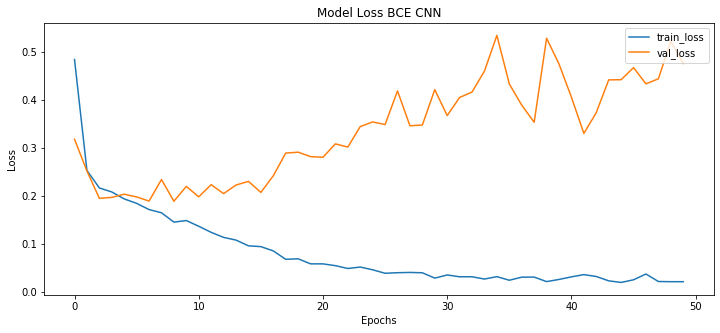

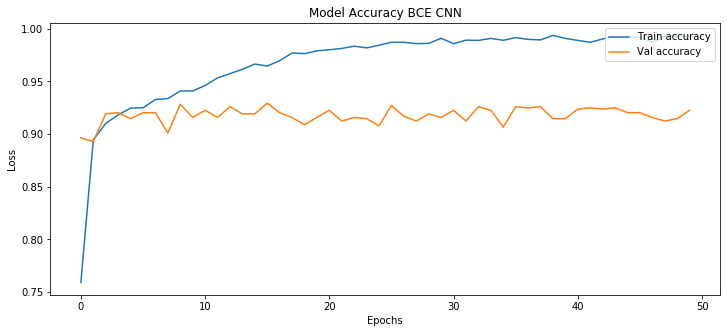

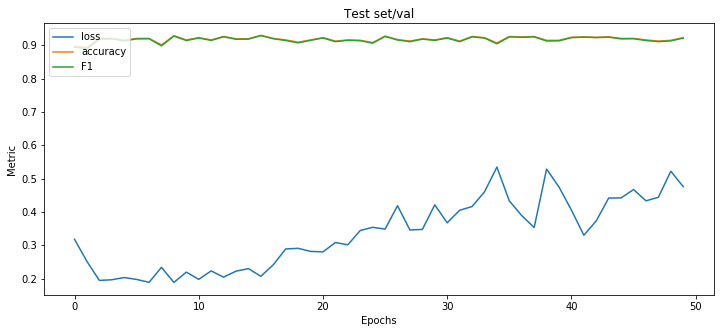

In [28]:
it_global = Input(shape=x_train.shape[1:])
cnn_glob = Conv1D(16, 5, activation='relu', padding="same")(it_global)
cnn_glob = Conv1D(16, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Conv1D(32, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = Conv1D(32, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Conv1D(64, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = Conv1D(64, 5, activation='relu', padding="same")(cnn_glob)
cnn_glob = MaxPooling1D(pool_size=5, strides=2)(cnn_glob)
cnn_glob = Flatten()(cnn_glob)
#until third block of shallue

##local part 
it_local = Input(shape=x_train_local.shape[1:])
cnn_loc = Conv1D(16, 5, activation='relu', padding="same")(it_local)
cnn_loc = Conv1D(16, 5, activation='relu', padding="same")(cnn_loc)
cnn_loc = MaxPooling1D(pool_size=7, strides=2)(cnn_loc)
cnn_loc = Conv1D(32, 5, activation='relu', padding="same")(cnn_loc) 
cnn_loc = Conv1D(32, 5, activation='relu', padding="same")(cnn_loc)
cnn_loc = MaxPooling1D(pool_size=7, strides=2)(cnn_loc)
cnn_loc = Flatten()(cnn_loc)

concat_cnn = keras.layers.Concatenate()([cnn_glob, cnn_loc])

fc = Dense(128, activation='relu')(concat_cnn)
fc = Dropout(0.5)(fc)
out = Dense(1, activation='sigmoid')(fc)
#simple fully connected model

it_total = [it_global, it_local]
CNN_shallue = Model(inputs=it_total, outputs=out)
CNN_shallue.summary()

train_model(CNN_shallue, [x_train, x_train_local], y_train[:,None], 
            e=50, BS=128, focal=False,alpha=0.6,save_f='./models/baseline_CNN_full.h5')

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.946200    0.934233  0.940178     0.924768  0.919113   
Confirmed            0.888412    0.907895  0.898048     0.924768  0.919113   

                F1 micro  Accuracy  
False Positive  0.924599  0.924599  
Confirmed       0.924599  0.924599

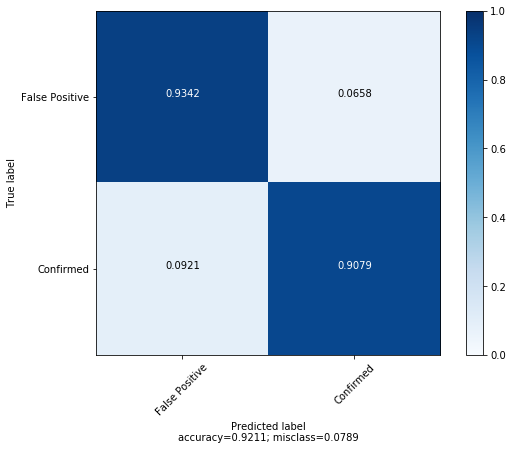

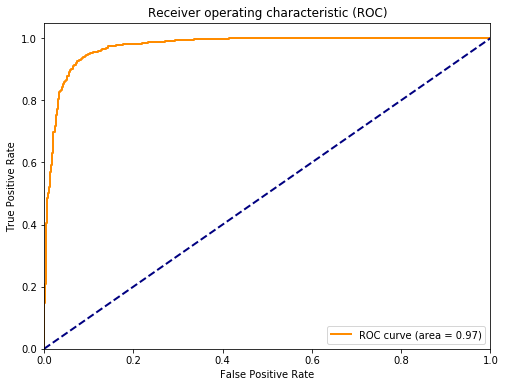

In [14]:
CNN_shallue_l = keras.models.load_model('./models/baseline_CNN_full.h5')

predichos=model_predict_class(CNN_shallue_l, [x_val,x_val_local]) #CNN_shallue_l.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double

predichos_prob = CNN_shallue_l.predict([x_val,x_val_local])
plot_ROC(y_val, predichos_prob)

Precision raw  Recall raw    F1 raw  F1 weighted  F1 macro  \
False Positive       0.961404    0.924115  0.942390     0.928799  0.923812   
Confirmed            0.876712    0.935673  0.905233     0.928799  0.923812   

                F1 micro  Accuracy  
False Positive  0.928342  0.928342  
Confirmed       0.928342  0.928342

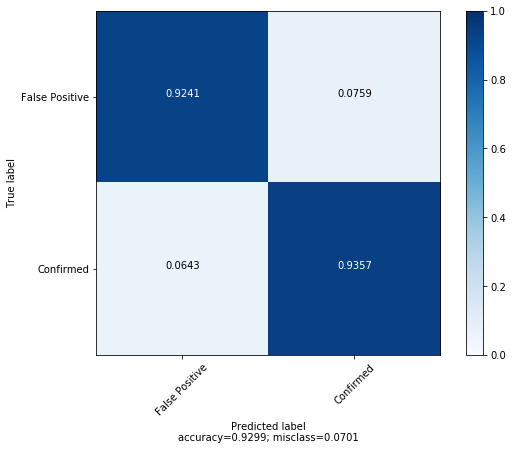

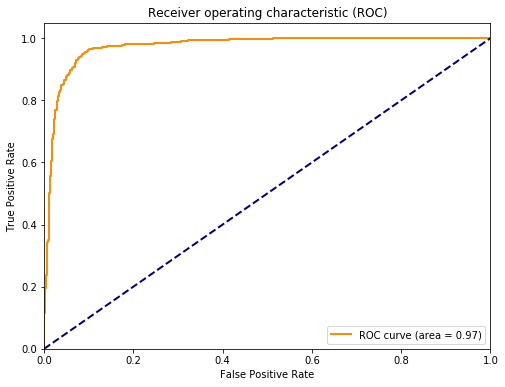

In [29]:
CNN_shallue_l = keras.models.load_model('./models/baseline_CNN_full.h5')

predichos=model_predict_class(CNN_shallue_l, [x_val,x_val_local]) #CNN_shallue_l.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double

predichos_prob = CNN_shallue_l.predict([x_val,x_val_local])
plot_ROC(y_val, predichos_prob) #mirrorring

## faltaría revisar efectividad de curvas originales de kepler..